# C3 Localization

In [1]:
import numpy as np
from coda.analysis import delay,iono,models
import matplotlib.pyplot as plt
import datetime
from coda.core import VLBIVis
import h5py
import glob
import datetime
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter,FuncFormatter,MaxNLocator
from matplotlib.patches import Rectangle

# Run the following grids
`(coda_env) [calvin@cedar1 pipelines]$ python two_baseline_delay_loc.py /scratch/calvin/calibrated_173098290_cals_per_baseline_pr_172988231_no_gbo_maser.h5 /scratch/calvin/loc_delay_173098290.h5`


# Tools for processing big grids

In [2]:
def get_prob_ra_dec(flogl,peak = None):
    """Marginalizes f['log_likelihood'] over DM0 and DM1."""
    if peak is None:
        peak,_ = get_max(flogl)
    shape = flogl.shape
    prob_ra_dec = np.zeros(shape[0:2],dtype = float)
    for ii in np.arange(shape[0]):
        for jj in np.arange(shape[1]):
            prob_ra_dec[ii,jj] = np.sum(np.exp(flogl[ii,jj] - peak))
    return prob_ra_dec

def get_prob_ra_dm0(flogl,peak = None):
    """Marginalises f['log_likelihood'] over dec and DM1."""
    if peak is None:
        peak,_ = get_max(flogl)
    print('Using maximum value of peak = {peak}')
    shape = flogl.shape
    prob_ra_dm0 = np.zeros((shape[0],shape[2]),dtype = float)
    _temp = flogl[0].copy()
    for ii in np.arange(shape[0]):
        print(f'Processing {ii}/{shape[0]}')
        _temp = flogl[ii] # read into mem
        prob_ra_dm0[ii,:] = np.sum(np.exp(_temp[:,:,:] - peak),axis = (0,2)) # (ra,dec,dm0,dm1) sum over dec & dm1
    return prob_ra_dm0

def get_prob_ra_dm1(flogl,peak = None):
    """Marginalises f['log_likelihood'] over dec and DM1."""
    if peak is None:
        peak,_ = get_max(flogl)
    print('Using maximum value of peak = {peak}')
    shape = flogl.shape
    prob_ra_dm1 = np.zeros((shape[0],shape[3]),dtype = float)
    _temp = flogl[0].copy()
    for ii in np.arange(shape[0]):
        print(f'Processing {ii}/{shape[0]}')
        _temp = flogl[ii] # read into mem
        prob_ra_dm1[ii,:] = np.sum(np.exp(_temp[:,:,:] - peak),axis = (0,1)) # (ra,dec,dm0,dm1) sum over dec & dm1
    return prob_ra_dm1

def get_prob_dec_dm0(flogl,peak = None):
    if peak is None:
        peak,_ = get_max(flogl)
    shape = flogl.shape
    prob_dec_dm0 = np.zeros((shape[1],shape[2]),dtype = float)
    for ii in np.arange(shape[1]):
        print(f'Processing {ii}/{shape[1]}')
        prob_dec_dm0[:] += np.sum(np.exp(flogl[ii] - peak), axis = -1) # sum over ra (with the +=); sum over dm1 when reading in bloks of size (dec,dm0,dm1)
    return prob_dec_dm0

def get_prob_dec_dm1(flogl,peak = None):
    if peak is None:
        peak,_ = get_max(flogl)
    shape = flogl.shape
    prob_dec_dm1 = np.zeros((shape[1],shape[3]),dtype = float)
    for ii in np.arange(shape[1]):
        print(f'Processing {ii}/{shape[1]}')
        prob_dec_dm1[:] += np.sum(np.exp(flogl[ii] - peak), axis = 1) # (ra,dec,dm0,dm1)
    return prob_dec_dm1

def get_prob_dm_dm(flogl,peak = None):
    """Marginalizes f['log_likelihood'] over DM0 and DM1."""
    if peak is None:
        peak,_ = get_max(flogl)
    shape = flogl.shape
    prob_dm_dm = np.zeros(shape[2:4],dtype = float)
    for ii in np.arange(shape[0]):
        print(f'Processing {ii}/{shape[0]}')
        for jj in np.arange(shape[1]):
            prob_dm_dm += np.exp(flogl[ii,jj] - peak)
    return prob_dm_dm
    
def get_max(dataset):
    shape = dataset.shape
    _chunk = np.zeros(shape[1:])
    _best_chunk = np.zeros(shape[1:])
    maximum_so_far = -np.inf
    iimax = 0
    jjmax = (np.nan,) * len(shape[1:])
    for ii in range(shape[0]):
        print(f'Processing {ii}/{shape[0]}')
        _chunk[:] = dataset[ii]
        if maximum_so_far < np.max(_chunk):
            iimax = ii # 
            _best_chunk = _chunk
            jjmax = np.unravel_index(np.argmax(_chunk),_chunk.shape)
            maximum_so_far = np.max(_chunk)
    indices = (iimax,) + jjmax
    return maximum_so_far,indices

def get_min(dataset):
    shape = dataset.shape
    _chunk = np.zeros(shape[1:])
    minimum = np.inf
    for ii in range(shape[0]):
        _chunk[:] = dataset[ii]
        minimum = min(minimum,np.min(_chunk))
    return minimum

def get_sum(dataset):
    shape = dataset.shape
    _chunk = np.zeros(shape[1:])
    _total = 0
    for ii in range(shape[0]):
        _chunk[:] = dataset[ii]
        _total += np.sum(_chunk)
    return _total    

def concatenate_grid_ra(glob_pattern,out_file):
    file_list = glob.glob(glob_pattern)
    print(file_list)
    n_ra = len(file_list)
    file_list.sort(key = lambda x: int(x.split('_')[-3]))
    # Initialize new file
    with h5py.File(out_file,'w-') as f:
        with h5py.File(file_list[0]) as f0:
            shape = list(f0['log_likelihood'].shape)
            shape[0] *= n_ra
            f.create_dataset('log_likelihood',dtype = f0['log_likelihood'].dtype,shape = shape)
            f.create_dataset('ra', dtype = f0['ra'].dtype, shape = shape[0])
            f.create_dataset('dec', dtype = f0['ra'].dtype, shape = shape[1])
            f.create_dataset('dm0', dtype = f0['ra'].dtype, shape = shape[2])
            f.create_dataset('dm1', dtype = f0['ra'].dtype, shape = shape[3])
            
    # Write loop
    with h5py.File(out_file,'r+') as f:
        for ii,file_name in enumerate(file_list):
            with h5py.File(file_name,'r') as fi:
                print(f'Processing {file_name}')
                print(get_max(fi['log_likelihood']))
                print(get_min(fi['log_likelihood']))
                f['log_likelihood'][ii::n_ra] = fi['log_likelihood'][:] # write comb
                print(fi['log_likelihood'][:])
                f['ra'][ii::n_ra] = fi['ra'][:]
                if file_name == file_list[0]:
                    f['dec'][:] = fi['dec'][:]
                    f['dm0'][:] = fi['dm0'][:]
                    f['dm1'][:] = fi['dm1'][:]
                if file_name != file_list[0]:
                    assert np.isclose(f['dec'][:], fi['dec'][:]).all(),"Grid axes different!"
                    assert np.isclose(f['dm0'][:], fi['dm0'][:]).all(),"Grid axes different!"
                    assert np.isclose(f['dm1'][:], fi['dm1'][:]).all(),"Grid axes different!"
    return out_file

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [93]:
!rm /scratch/calvin/grid_loc_172924963_iono_center12.h5

In [94]:
concatenate_grid_ra('/scratch/calvin/grid_loc_172924963_iono_center12_*_of_10.h5',
                    '/scratch/calvin/grid_loc_172924963_iono_center12.h5')

['/scratch/calvin/grid_loc_172924963_iono_center12_4_of_10.h5', '/scratch/calvin/grid_loc_172924963_iono_center12_0_of_10.h5', '/scratch/calvin/grid_loc_172924963_iono_center12_1_of_10.h5', '/scratch/calvin/grid_loc_172924963_iono_center12_6_of_10.h5', '/scratch/calvin/grid_loc_172924963_iono_center12_8_of_10.h5', '/scratch/calvin/grid_loc_172924963_iono_center12_2_of_10.h5', '/scratch/calvin/grid_loc_172924963_iono_center12_7_of_10.h5', '/scratch/calvin/grid_loc_172924963_iono_center12_5_of_10.h5', '/scratch/calvin/grid_loc_172924963_iono_center12_3_of_10.h5', '/scratch/calvin/grid_loc_172924963_iono_center12_9_of_10.h5']
Processing /scratch/calvin/grid_loc_172924963_iono_center12_0_of_10.h5
Processing 0/30
Processing 1/30
Processing 2/30
Processing 3/30
Processing 4/30
Processing 5/30
Processing 6/30
Processing 7/30
Processing 8/30
Processing 9/30
Processing 10/30
Processing 11/30
Processing 12/30
Processing 13/30
Processing 14/30
Processing 15/30
Processing 16/30
Processing 17/30
Pr

Processing /scratch/calvin/grid_loc_172924963_iono_center12_1_of_10.h5
Processing 0/30
Processing 1/30
Processing 2/30
Processing 3/30
Processing 4/30
Processing 5/30
Processing 6/30
Processing 7/30
Processing 8/30
Processing 9/30
Processing 10/30
Processing 11/30
Processing 12/30
Processing 13/30
Processing 14/30
Processing 15/30
Processing 16/30
Processing 17/30
Processing 18/30
Processing 19/30
Processing 20/30
Processing 21/30
Processing 22/30
Processing 23/30
Processing 24/30
Processing 25/30
Processing 26/30
Processing 27/30
Processing 28/30
Processing 29/30
(-1284.5203052421248, (28, 3, 149, 78))
-2019.117707026884
[[[[-1758.08820637 -1775.21546683 -1776.38796023 ... -1717.15911505
    -1703.23238854 -1688.22242365]
   [-1706.5108282  -1723.63808865 -1724.81058205 ... -1665.58173688
    -1651.65501037 -1636.64504547]
   [-1661.23406433 -1678.36132479 -1679.53381819 ... -1620.30497301
    -1606.3782465  -1591.36828161]
   ...
   [-1693.14154395 -1710.26880441 -1711.44129781 ... -

Processing 1/30
Processing 2/30
Processing 3/30
Processing 4/30
Processing 5/30
Processing 6/30
Processing 7/30
Processing 8/30
Processing 9/30
Processing 10/30
Processing 11/30
Processing 12/30
Processing 13/30
Processing 14/30
Processing 15/30
Processing 16/30
Processing 17/30
Processing 18/30
Processing 19/30
Processing 20/30
Processing 21/30
Processing 22/30
Processing 23/30
Processing 24/30
Processing 25/30
Processing 26/30
Processing 27/30
Processing 28/30
Processing 29/30
(-1285.5016119929937, (28, 0, 149, 76))
-2018.572927393968
[[[[-1751.80779297 -1765.3565723  -1762.56634567 ... -1702.88578499
    -1688.51310098 -1673.8206872 ]
   [-1699.41247914 -1712.96125847 -1710.17103184 ... -1650.49047116
    -1636.11778715 -1621.42537337]
   [-1655.65869424 -1669.20747357 -1666.41724694 ... -1606.73668626
    -1592.36400225 -1577.67158847]
   ...
   [-1696.65824851 -1710.20702784 -1707.41680121 ... -1647.73624053
    -1633.36355652 -1618.67114274]
   [-1691.74853169 -1705.29731102 -170

Processing 1/30
Processing 2/30
Processing 3/30
Processing 4/30
Processing 5/30
Processing 6/30
Processing 7/30
Processing 8/30
Processing 9/30
Processing 10/30
Processing 11/30
Processing 12/30
Processing 13/30
Processing 14/30
Processing 15/30
Processing 16/30
Processing 17/30
Processing 18/30
Processing 19/30
Processing 20/30
Processing 21/30
Processing 22/30
Processing 23/30
Processing 24/30
Processing 25/30
Processing 26/30
Processing 27/30
Processing 28/30
Processing 29/30
(-1286.1550953715018, (29, 54, 156, 42))
-2020.4282116553466
[[[[-1743.92823898 -1753.76118996 -1747.07007829 ... -1687.7437775
    -1673.10270465 -1658.90421829]
   [-1691.28402467 -1701.11697564 -1694.42586398 ... -1635.09956319
    -1620.45849033 -1606.26000397]
   [-1649.59081938 -1659.42377036 -1652.73265869 ... -1593.4063579
    -1578.76528505 -1564.56679869]
   ...
   [-1699.46868139 -1709.30163237 -1702.6105207  ... -1643.28421991
    -1628.64314706 -1614.4446607 ]
   [-1695.54048453 -1705.37343551 -169

Processing 1/30
Processing 2/30
Processing 3/30
Processing 4/30
Processing 5/30
Processing 6/30
Processing 7/30
Processing 8/30
Processing 9/30
Processing 10/30
Processing 11/30
Processing 12/30
Processing 13/30
Processing 14/30
Processing 15/30
Processing 16/30
Processing 17/30
Processing 18/30
Processing 19/30
Processing 20/30
Processing 21/30
Processing 22/30
Processing 23/30
Processing 24/30
Processing 25/30
Processing 26/30
Processing 27/30
Processing 28/30
Processing 29/30
(-1285.586206473486, (27, 10, 150, 71))
-2019.9820182733706
[[[[-1734.56229886 -1740.59121084 -1730.11089719 ... -1671.93675479
    -1657.2056818  -1643.66911574]
   [-1682.25604721 -1688.28495919 -1677.80464555 ... -1619.63050315
    -1604.89943016 -1591.36286409]
   [-1643.15203018 -1649.18094216 -1638.70062852 ... -1580.52648612
    -1565.79541312 -1552.25884706]
   ...
   [-1701.52692939 -1707.55584137 -1697.07552773 ... -1638.90138533
    -1624.17031234 -1610.63374627]
   [-1698.61014569 -1704.63905767 -16

Processing 1/30
Processing 2/30
Processing 3/30
Processing 4/30
Processing 5/30
Processing 6/30
Processing 7/30
Processing 8/30
Processing 9/30
Processing 10/30
Processing 11/30
Processing 12/30
Processing 13/30
Processing 14/30
Processing 15/30
Processing 16/30
Processing 17/30
Processing 18/30
Processing 19/30
Processing 20/30
Processing 21/30
Processing 22/30
Processing 23/30
Processing 24/30
Processing 25/30
Processing 26/30
Processing 27/30
Processing 28/30
Processing 29/30
(-1285.280062998903, (27, 9, 150, 70))
-2017.5939742196942
[[[[-1723.84740144 -1726.03399414 -1711.92421685 ... -1655.68016221
    -1641.03596006 -1628.31883899]
   [-1672.4755377  -1674.6621304  -1660.55235311 ... -1604.30829848
    -1589.66409632 -1576.94697525]
   [-1636.47205649 -1638.65864919 -1624.5488719  ... -1568.30481727
    -1553.66061511 -1540.94349404]
   ...
   [-1702.79925438 -1704.98584708 -1690.87606979 ... -1634.63201516
    -1619.987813   -1607.27069193]
   [-1700.91583224 -1703.10242494 -168

Processing 1/30
Processing 2/30
Processing 3/30
Processing 4/30
Processing 5/30
Processing 6/30
Processing 7/30
Processing 8/30
Processing 9/30
Processing 10/30
Processing 11/30
Processing 12/30
Processing 13/30
Processing 14/30
Processing 15/30
Processing 16/30
Processing 17/30
Processing 18/30
Processing 19/30
Processing 20/30
Processing 21/30
Processing 22/30
Processing 23/30
Processing 24/30
Processing 25/30
Processing 26/30
Processing 27/30
Processing 28/30
Processing 29/30
(-1285.951474126838, (27, 4, 150, 80))
-2017.5922948041941
[[[[-1711.94326041 -1710.29927875 -1692.7653849  ... -1639.1978245
    -1624.81358446 -1613.06107198]
   [-1662.10320774 -1660.45922607 -1642.92533222 ... -1589.35777182
    -1574.97353179 -1563.2210193 ]
   [-1629.68618175 -1628.04220008 -1610.50830623 ... -1556.94074583
    -1542.5565058  -1530.80399331]
   ...
   [-1703.26469301 -1701.62071135 -1684.0868175  ... -1630.5192571
    -1616.13501706 -1604.38250458]
   [-1702.42885465 -1700.78487298 -1683.

Processing 1/30
Processing 2/30
Processing 3/30
Processing 4/30
Processing 5/30
Processing 6/30
Processing 7/30
Processing 8/30
Processing 9/30
Processing 10/30
Processing 11/30
Processing 12/30
Processing 13/30
Processing 14/30
Processing 15/30
Processing 16/30
Processing 17/30
Processing 18/30
Processing 19/30
Processing 20/30
Processing 21/30
Processing 22/30
Processing 23/30
Processing 24/30
Processing 25/30
Processing 26/30
Processing 27/30
Processing 28/30
Processing 29/30
(-1284.7888946263388, (27, 0, 150, 77))
-2018.2591990791418
[[[[-1699.02913225 -1693.61574688 -1672.90562968 ... -1622.71843716
    -1608.76131633 -1598.10453231]
   [-1651.31059724 -1645.89721187 -1625.18709468 ... -1574.99990215
    -1561.04278133 -1550.3859973 ]
   [-1622.93260058 -1617.51921522 -1596.80909802 ... -1546.6219055
    -1532.66478467 -1522.00800065]
   ...
   [-1702.91547041 -1697.50208504 -1676.79196785 ... -1626.60477532
    -1612.6476545  -1601.99087047]
   [-1703.13393759 -1697.72055222 -167

Processing 1/30
Processing 2/30
Processing 3/30
Processing 4/30
Processing 5/30
Processing 6/30
Processing 7/30
Processing 8/30
Processing 9/30
Processing 10/30
Processing 11/30
Processing 12/30
Processing 13/30
Processing 14/30
Processing 15/30
Processing 16/30
Processing 17/30
Processing 18/30
Processing 19/30
Processing 20/30
Processing 21/30
Processing 22/30
Processing 23/30
Processing 24/30
Processing 25/30
Processing 26/30
Processing 27/30
Processing 28/30
Processing 29/30
(-1284.7346682387192, (27, 0, 150, 77))
-2018.3073248210376
[[[[-1685.30073074 -1676.2272589  -1652.6277263  ... -1606.47194536
    -1593.10114214 -1583.65570593]
   [-1640.27697835 -1631.20350651 -1607.60397391 ... -1561.44819297
    -1548.07738975 -1538.63195354]
   [-1616.34970982 -1607.27623798 -1583.67670539 ... -1537.52092444
    -1524.15012122 -1514.70468501]
   ...
   [-1701.75716686 -1692.68369502 -1669.08416242 ... -1622.92838148
    -1609.55757826 -1600.11214205]
   [-1703.02939549 -1693.95592365 -16

Processing /scratch/calvin/grid_loc_172924963_iono_center12_9_of_10.h5
Processing 0/30
Processing 1/30
Processing 2/30
Processing 3/30
Processing 4/30
Processing 5/30
Processing 6/30
Processing 7/30
Processing 8/30
Processing 9/30
Processing 10/30
Processing 11/30
Processing 12/30
Processing 13/30
Processing 14/30
Processing 15/30
Processing 16/30
Processing 17/30
Processing 18/30
Processing 19/30
Processing 20/30
Processing 21/30
Processing 22/30
Processing 23/30
Processing 24/30
Processing 25/30
Processing 26/30
Processing 27/30
Processing 28/30
Processing 29/30
(-1285.4565105498073, (29, 37, 156, 56))
-2017.3071064465137
[[[[-1670.96690395 -1658.38887302 -1632.22150424 ... -1590.68593282
    -1578.05081921 -1569.91563804]
   [-1629.18617174 -1616.6081408  -1590.44077202 ... -1548.9052006
    -1536.27008699 -1528.13490582]
   [-1610.07344341 -1597.49541247 -1571.32804369 ... -1529.79247227
    -1517.15735866 -1509.02217749]
   ...
   [-1699.80865677 -1687.23062584 -1661.06325706 ... 

'/scratch/calvin/grid_loc_172924963_iono_center12.h5'

In [82]:
glob.glob('/scratch/calvin/grid_loc_172924963_iono_center12_*_of_10.h5')

['/scratch/calvin/grid_loc_172924963_iono_center12_4_of_10.h5',
 '/scratch/calvin/grid_loc_172924963_iono_center12_0_of_10.h5',
 '/scratch/calvin/grid_loc_172924963_iono_center12_1_of_10.h5',
 '/scratch/calvin/grid_loc_172924963_iono_center12_6_of_10.h5',
 '/scratch/calvin/grid_loc_172924963_iono_center12_8_of_10.h5',
 '/scratch/calvin/grid_loc_172924963_iono_center12_2_of_10.h5',
 '/scratch/calvin/grid_loc_172924963_iono_center12_7_of_10.h5',
 '/scratch/calvin/grid_loc_172924963_iono_center12_5_of_10.h5',
 '/scratch/calvin/grid_loc_172924963_iono_center12_3_of_10.h5',
 '/scratch/calvin/grid_loc_172924963_iono_center12_9_of_10.h5']

# Compare Grid to delay-only coarse grid

# Tools for plotting ra vs dec

In [95]:
def set_lim(fig,lim_list,axis = 'x'):
    ndim = int(np.sqrt(len(fig.axes)))
    for ii in range(ndim):
        for jj in range(ndim):
            if axis == 'x':
                fig.axes[ndim*ii+jj].set_xlim(lim_list[jj])
                x_formatter = ScalarFormatter(useOffset=False)
                fig.axes[ndim*ii+jj].xaxis.set_major_formatter(x_formatter)
            if axis == 'y':
                y_formatter = ScalarFormatter(useOffset=False)
                fig.axes[ndim*ii+jj].yaxis.set_major_formatter(y_formatter)
                if ii != jj:
                    fig.axes[ndim*ii+jj].set_ylim(lim_list[ii])

In [96]:
%matplotlib notebook

In [97]:
with h5py.File('/scratch/calvin/grid_loc_172924963_iono_center12.h5','r') as f:
    grid_max,indices = get_max(f['log_likelihood'])
    print(f['log_likelihood'][0])
    params = [f[dim][ii] for ii,dim in zip(indices,['ra','dec','dm0','dm1'])]
    print(params)
    print(grid_max)
    print(f['log_likelihood'][indices])

Processing 0/300
Processing 1/300
Processing 2/300
Processing 3/300
Processing 4/300
Processing 5/300
Processing 6/300
Processing 7/300
Processing 8/300
Processing 9/300
Processing 10/300
Processing 11/300
Processing 12/300
Processing 13/300
Processing 14/300
Processing 15/300
Processing 16/300
Processing 17/300
Processing 18/300
Processing 19/300
Processing 20/300
Processing 21/300
Processing 22/300
Processing 23/300
Processing 24/300
Processing 25/300
Processing 26/300
Processing 27/300
Processing 28/300
Processing 29/300
Processing 30/300
Processing 31/300
Processing 32/300
Processing 33/300
Processing 34/300
Processing 35/300
Processing 36/300
Processing 37/300
Processing 38/300
Processing 39/300
Processing 40/300
Processing 41/300
Processing 42/300
Processing 43/300
Processing 44/300
Processing 45/300
Processing 46/300
Processing 47/300
Processing 48/300
Processing 49/300
Processing 50/300
Processing 51/300
Processing 52/300
Processing 53/300
Processing 54/300
Processing 55/300
Pr

<IPython.core.display.Javascript object>


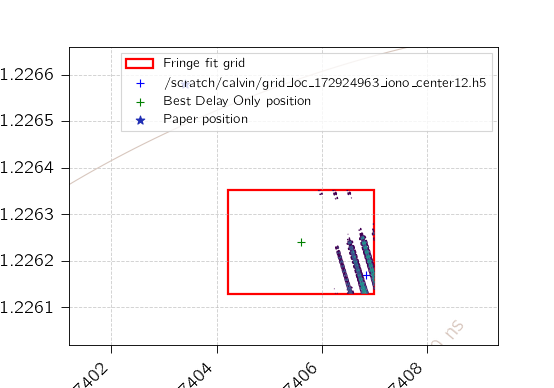

Processing 0/300
Processing 1/300
Processing 2/300
Processing 3/300
Processing 4/300
Processing 5/300
Processing 6/300
Processing 7/300
Processing 8/300
Processing 9/300
Processing 10/300
Processing 11/300
Processing 12/300
Processing 13/300
Processing 14/300
Processing 15/300
Processing 16/300
Processing 17/300
Processing 18/300
Processing 19/300
Processing 20/300
Processing 21/300
Processing 22/300
Processing 23/300
Processing 24/300
Processing 25/300
Processing 26/300
Processing 27/300
Processing 28/300
Processing 29/300
Processing 30/300
Processing 31/300
Processing 32/300
Processing 33/300
Processing 34/300
Processing 35/300
Processing 36/300
Processing 37/300
Processing 38/300
Processing 39/300
Processing 40/300
Processing 41/300
Processing 42/300
Processing 43/300
Processing 44/300
Processing 45/300
Processing 46/300
Processing 47/300
Processing 48/300
Processing 49/300
Processing 50/300
Processing 51/300
Processing 52/300
Processing 53/300
Processing 54/300
Processing 55/300
Pr

Processing 143/300
Processing 144/300
Processing 145/300
Processing 146/300
Processing 147/300
Processing 148/300
Processing 149/300
Processing 150/300
Processing 151/300
Processing 152/300
Processing 153/300
Processing 154/300
Processing 155/300
Processing 156/300
Processing 157/300
Processing 158/300
Processing 159/300
Processing 160/300
Processing 161/300
Processing 162/300
Processing 163/300
Processing 164/300
Processing 165/300
Processing 166/300
Processing 167/300
Processing 168/300
Processing 169/300
Processing 170/300
Processing 171/300
Processing 172/300
Processing 173/300
Processing 174/300
Processing 175/300
Processing 176/300
Processing 177/300
Processing 178/300
Processing 179/300
Processing 180/300
Processing 181/300
Processing 182/300
Processing 183/300
Processing 184/300
Processing 185/300
Processing 186/300
Processing 187/300
Processing 188/300
Processing 189/300
Processing 190/300
Processing 191/300
Processing 192/300
Processing 193/300
Processing 194/300
Processing 1

Processing 281/300
Processing 282/300
Processing 283/300
Processing 284/300
Processing 285/300
Processing 286/300
Processing 287/300
Processing 288/300
Processing 289/300
Processing 290/300
Processing 291/300
Processing 292/300
Processing 293/300
Processing 294/300
Processing 295/300
Processing 296/300
Processing 297/300
Processing 298/300
Processing 299/300
<p O> / <p> : 10.274068347005773 21.226170419841353 1.2259596868392416e-07 -3.6351688567848286e-07


In [98]:
plt.style.use('/home/calvin/frb-vlbi-loc/plot_scripts/paper_sty.mplstyle')
c3_fig = plt.figure(figsize = (88 / 25.4, 88 * 0.7 / 25.4))
ax_abs = plt.gca()

for crab in [False]:
    if crab: # C3
        fringe_fit_file = '/scratch/calvin/grid_loc_173098290_iono_wide3.h5'
        delay_only_file = '/scratch/calvin/loc_delay_173098290.h5'
    if not crab: # FRB
        fringe_fit_file = '/scratch/calvin/grid_loc_172924963_iono_center12.h5'
        delay_only_file = '/scratch/calvin/loc_delay_172924963_flagged.h5'
        fringe_fit_files = ['/scratch/calvin/grid_loc_172924963_iono_center12.h5']
    for fringe_fit_file in fringe_fit_files:
        with h5py.File(fringe_fit_file,'r') as f:
            R,D = np.meshgrid(f['ra'][:],f['dec'][:],indexing='ij')
            grid_lim = Rectangle((f['ra'][0],f['dec'][0]), f['ra'][-1] - f['ra'][0],
                  f['dec'][-1] - f['dec'][0],linewidth=1, edgecolor='r', facecolor='none',label = 'Fringe fit grid')
            ax_abs.add_patch(grid_lim)

            prob_ra_dec = get_prob_ra_dec(f['log_likelihood'])
            prob_dm_dm = get_prob_dm_dm(f['log_likelihood'])
            prob_ra_dec /= np.sum(prob_ra_dec)
            prob_dm_dm /= np.sum(prob_dm_dm)
            ax_abs.contour(R,D,np.log10(prob_ra_dec),levels = np.linspace(-6,0,num=5))
            loc_ra = np.sum(f['ra'][:][:,None] * prob_ra_dec)
            loc_dec = np.sum(f['dec'][:][None,:] * prob_ra_dec)
            loc_dm0 = np.sum(f['dm0'][:][:,None] * prob_dm_dm)
            loc_dm1 = np.sum(f['dm1'][:][None,:] * prob_dm_dm)
            print('<p O> / <p> :',loc_ra,loc_dec,loc_dm0,loc_dm1)
            ax_abs.scatter([loc_ra],[loc_dec],marker = '+',color = 'blue', label = f'{fringe_fit_file}')
    with h5py.File(delay_only_file,'r') as f:
        R,D = np.meshgrid(f['ra'][:],f['dec'][:],indexing='ij')
        LL = f['log_likelihood'][:]
        LL -= np.max(LL)
        CS1 = plt.contour(R,D,LL,levels = [-16,-9,-4,-1,0],cmap = 'twilight')
        iira, iidec = np.unravel_index(np.argmax(LL),LL.shape)
        loc_ra = f['ra'][iira]
        loc_dec = f['dec'][iidec]
        plt.scatter([loc_ra],[loc_dec],marker = '+',color = 'green',label = 'Best Delay Only position')
        set_lim(c3_fig,[f['ra'][0],f['ra'][-1]],'x')
        plt.xticks(rotation=45, ha='right')
        set_lim(c3_fig,[f['dec'][0],f['dec'][-1]],'y')

        fmt = {}
        strs = ['40 ns',r'$\pm 30$ ns',r'$\pm 20$ ns',r'$\pm 10$ ns']
        for l, s in zip(CS1.levels, strs):
            fmt[l] = s

        # Label every other level using strings
        ax_abs.clabel(CS1, CS1.levels, inline=True, fmt=fmt, fontsize=10)

    if crab:
        ax_abs.scatter([83.63303797583967],[22.014501808827642],marker = '*',color = 'red',label = 'True Crab position') # proper-motion corrected Crab position
        #set_labels(plt.gcf())
        ax_rel_y = ax_abs.twinx()
        ax_rel_x = ax_abs.twiny()

        x1, x2 = ax_abs.get_xlim()
        y1, y2 = ax_abs.get_ylim()
        ax_rel_y.set_ylim((y1 - 22.014501808827642) * 3600, (y2 - 22.014501808827642) * 3600)
        ax_rel_x.set_xlim((x1 - 83.63303797583967) * 3600, (x2 - 83.63303797583967) * 3600)
        ax_rel_y.set_ylabel('Dec Offset (arcsec)')
        ax_rel_x.set_xlabel('RA Offset (arcsec)')
        ax_abs.legend()
        plt.savefig('/home/calvin/frb-vlbi-loc/figures/c3_loc.pdf',dpi=300)
    else:
        ax_abs.scatter([10.2740340 ],[ 21.226579],marker= '*',label = 'Paper position')
        ax_abs.legend()
        plt.savefig('/home/calvin/frb-vlbi-loc/figures/frb_loc.pdf',dpi=300)

<IPython.core.display.Javascript object>


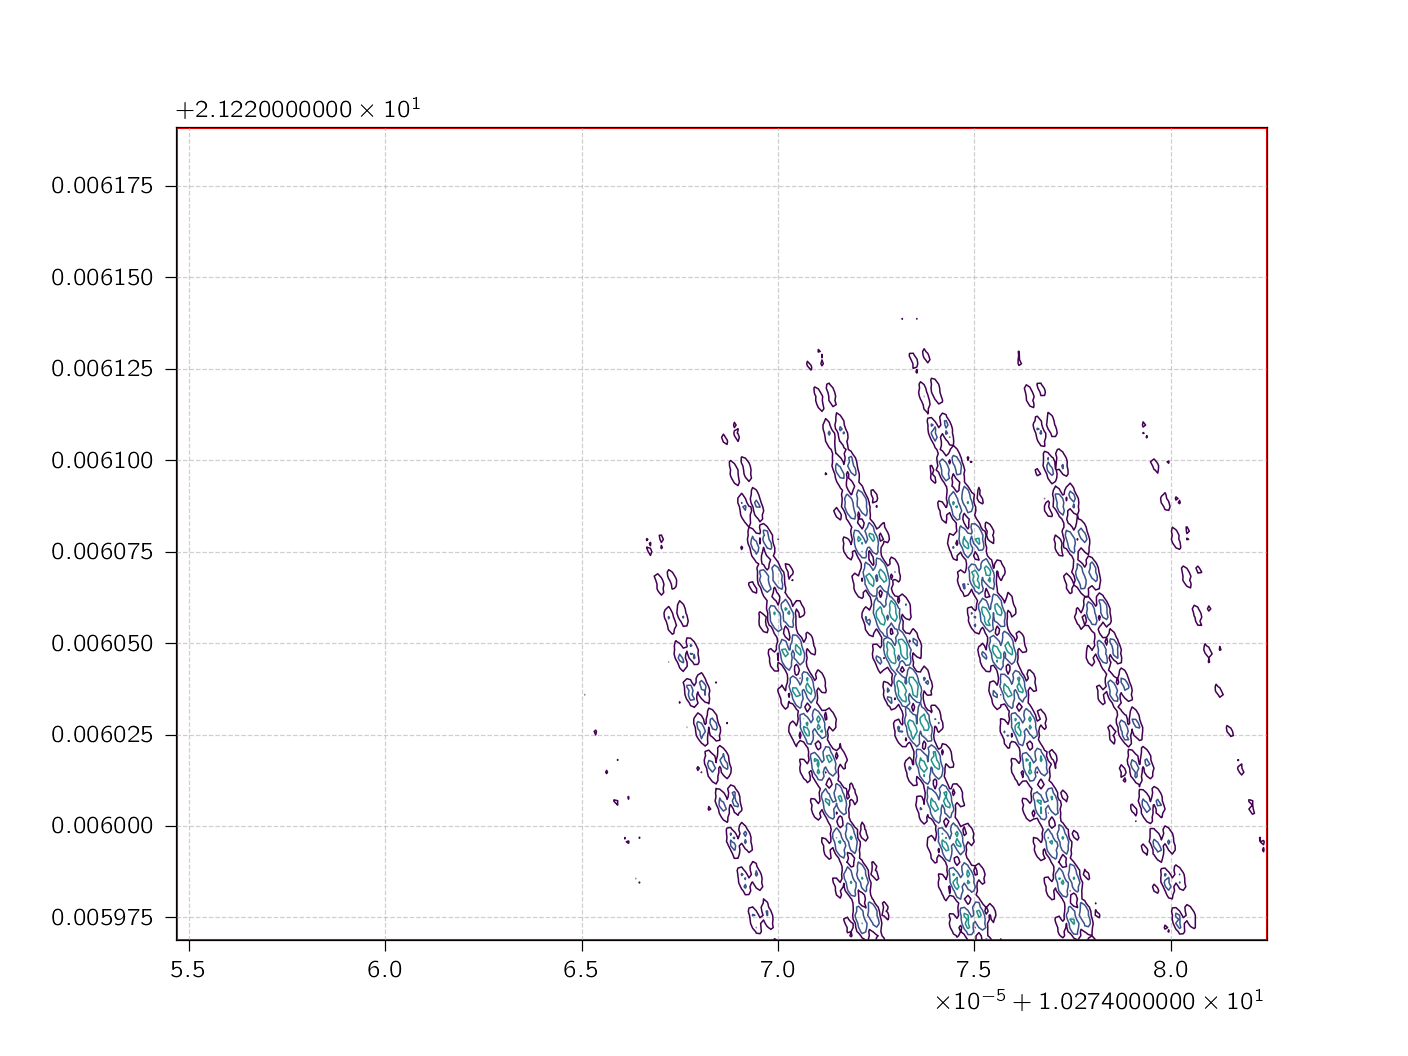

Processing 0/300
Processing 1/300
Processing 2/300
Processing 3/300
Processing 4/300
Processing 5/300
Processing 6/300
Processing 7/300
Processing 8/300
Processing 9/300
Processing 10/300
Processing 11/300
Processing 12/300
Processing 13/300
Processing 14/300
Processing 15/300
Processing 16/300
Processing 17/300
Processing 18/300
Processing 19/300
Processing 20/300
Processing 21/300
Processing 22/300
Processing 23/300
Processing 24/300
Processing 25/300
Processing 26/300
Processing 27/300
Processing 28/300
Processing 29/300
Processing 30/300
Processing 31/300
Processing 32/300
Processing 33/300
Processing 34/300
Processing 35/300
Processing 36/300
Processing 37/300
Processing 38/300
Processing 39/300
Processing 40/300
Processing 41/300
Processing 42/300
Processing 43/300
Processing 44/300
Processing 45/300
Processing 46/300
Processing 47/300
Processing 48/300
Processing 49/300
Processing 50/300
Processing 51/300
Processing 52/300
Processing 53/300
Processing 54/300
Processing 55/300
Pr

Processing 144/300
Processing 145/300
Processing 146/300
Processing 147/300
Processing 148/300
Processing 149/300
Processing 150/300
Processing 151/300
Processing 152/300
Processing 153/300
Processing 154/300
Processing 155/300
Processing 156/300
Processing 157/300
Processing 158/300
Processing 159/300
Processing 160/300
Processing 161/300
Processing 162/300
Processing 163/300
Processing 164/300
Processing 165/300
Processing 166/300
Processing 167/300
Processing 168/300
Processing 169/300
Processing 170/300
Processing 171/300
Processing 172/300
Processing 173/300
Processing 174/300
Processing 175/300
Processing 176/300
Processing 177/300
Processing 178/300
Processing 179/300
Processing 180/300
Processing 181/300
Processing 182/300
Processing 183/300
Processing 184/300
Processing 185/300
Processing 186/300
Processing 187/300
Processing 188/300
Processing 189/300
Processing 190/300
Processing 191/300
Processing 192/300
Processing 193/300
Processing 194/300
Processing 195/300
Processing 1

Processing 282/300
Processing 283/300
Processing 284/300
Processing 285/300
Processing 286/300
Processing 287/300
Processing 288/300
Processing 289/300
Processing 290/300
Processing 291/300
Processing 292/300
Processing 293/300
Processing 294/300
Processing 295/300
Processing 296/300
Processing 297/300
Processing 298/300
Processing 299/300


<IPython.core.display.Javascript object>


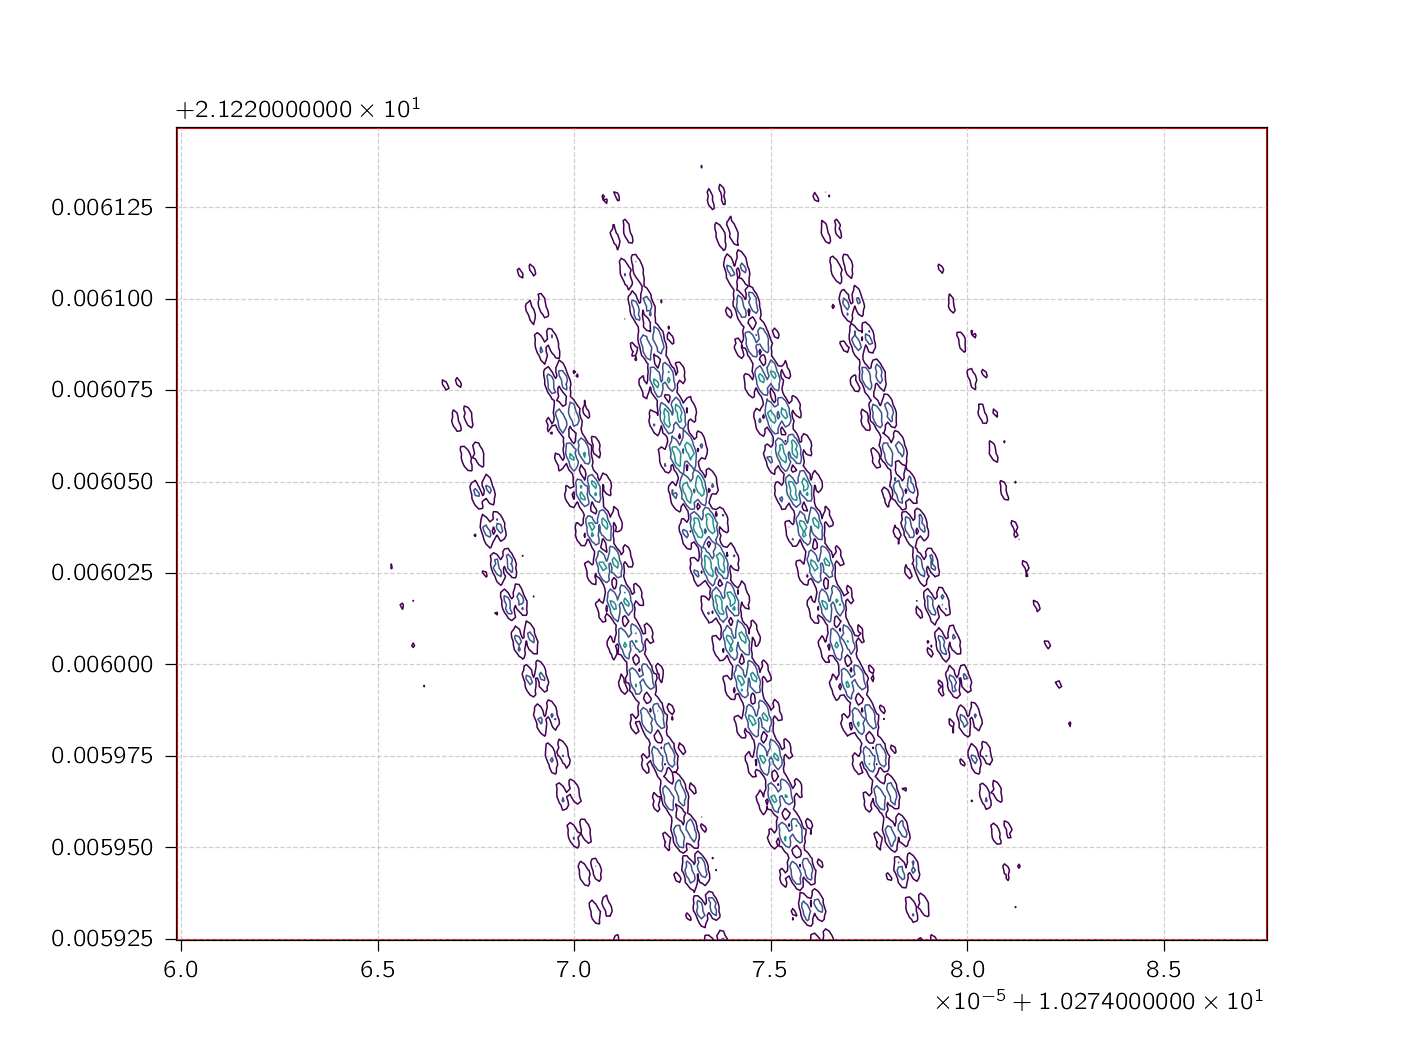

Processing 0/300
Processing 1/300
Processing 2/300
Processing 3/300
Processing 4/300
Processing 5/300
Processing 6/300
Processing 7/300
Processing 8/300
Processing 9/300
Processing 10/300
Processing 11/300
Processing 12/300
Processing 13/300
Processing 14/300
Processing 15/300
Processing 16/300
Processing 17/300
Processing 18/300
Processing 19/300
Processing 20/300
Processing 21/300
Processing 22/300
Processing 23/300
Processing 24/300
Processing 25/300
Processing 26/300
Processing 27/300
Processing 28/300
Processing 29/300
Processing 30/300
Processing 31/300
Processing 32/300
Processing 33/300
Processing 34/300
Processing 35/300
Processing 36/300
Processing 37/300
Processing 38/300
Processing 39/300
Processing 40/300
Processing 41/300
Processing 42/300
Processing 43/300
Processing 44/300
Processing 45/300
Processing 46/300
Processing 47/300
Processing 48/300
Processing 49/300
Processing 50/300
Processing 51/300
Processing 52/300
Processing 53/300
Processing 54/300
Processing 55/300
Pr

Processing 146/300
Processing 147/300
Processing 148/300
Processing 149/300
Processing 150/300
Processing 151/300
Processing 152/300
Processing 153/300
Processing 154/300
Processing 155/300
Processing 156/300
Processing 157/300
Processing 158/300
Processing 159/300
Processing 160/300
Processing 161/300
Processing 162/300
Processing 163/300
Processing 164/300
Processing 165/300
Processing 166/300
Processing 167/300
Processing 168/300
Processing 169/300
Processing 170/300
Processing 171/300
Processing 172/300
Processing 173/300
Processing 174/300
Processing 175/300
Processing 176/300
Processing 177/300
Processing 178/300
Processing 179/300
Processing 180/300
Processing 181/300
Processing 182/300
Processing 183/300
Processing 184/300
Processing 185/300
Processing 186/300
Processing 187/300
Processing 188/300
Processing 189/300
Processing 190/300
Processing 191/300
Processing 192/300
Processing 193/300
Processing 194/300
Processing 195/300
Processing 196/300
Processing 197/300
Processing 1

Processing 284/300
Processing 285/300
Processing 286/300
Processing 287/300
Processing 288/300
Processing 289/300
Processing 290/300
Processing 291/300
Processing 292/300
Processing 293/300
Processing 294/300
Processing 295/300
Processing 296/300
Processing 297/300
Processing 298/300
Processing 299/300


<IPython.core.display.Javascript object>


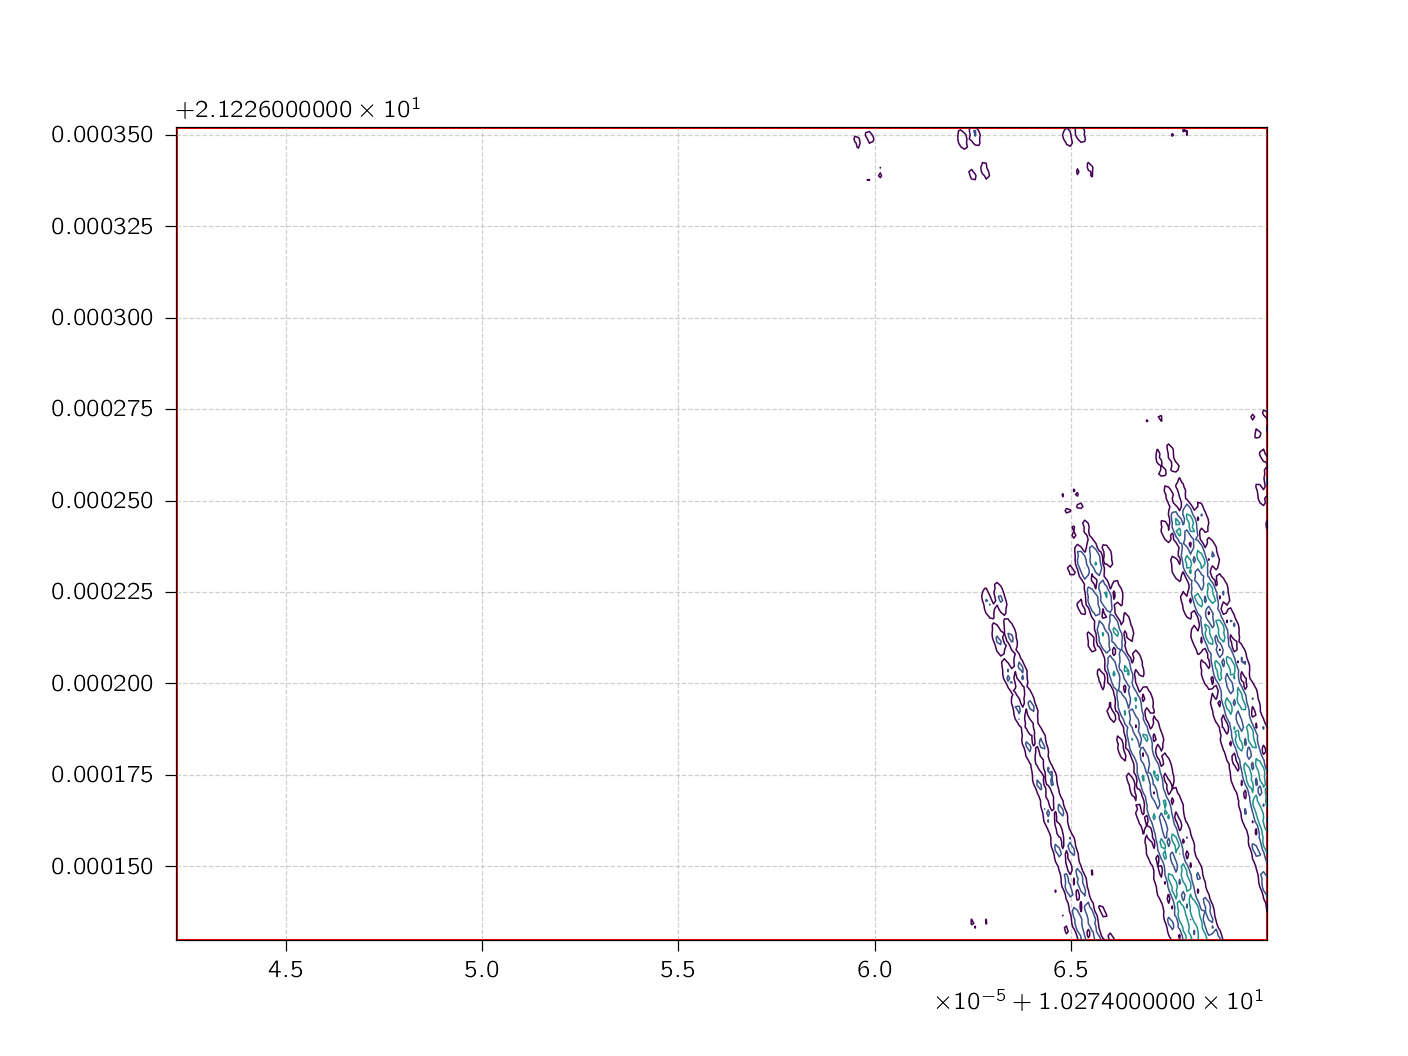

Processing 0/300
Processing 1/300
Processing 2/300
Processing 3/300
Processing 4/300
Processing 5/300
Processing 6/300
Processing 7/300
Processing 8/300
Processing 9/300
Processing 10/300
Processing 11/300
Processing 12/300
Processing 13/300
Processing 14/300
Processing 15/300
Processing 16/300
Processing 17/300
Processing 18/300
Processing 19/300
Processing 20/300
Processing 21/300
Processing 22/300
Processing 23/300
Processing 24/300
Processing 25/300
Processing 26/300
Processing 27/300
Processing 28/300
Processing 29/300
Processing 30/300
Processing 31/300
Processing 32/300
Processing 33/300
Processing 34/300
Processing 35/300
Processing 36/300
Processing 37/300
Processing 38/300
Processing 39/300
Processing 40/300
Processing 41/300
Processing 42/300
Processing 43/300
Processing 44/300
Processing 45/300
Processing 46/300
Processing 47/300
Processing 48/300
Processing 49/300
Processing 50/300
Processing 51/300
Processing 52/300
Processing 53/300
Processing 54/300
Processing 55/300
Pr

Processing 145/300
Processing 146/300
Processing 147/300
Processing 148/300
Processing 149/300
Processing 150/300
Processing 151/300
Processing 152/300
Processing 153/300
Processing 154/300
Processing 155/300
Processing 156/300
Processing 157/300
Processing 158/300
Processing 159/300
Processing 160/300
Processing 161/300
Processing 162/300
Processing 163/300
Processing 164/300
Processing 165/300
Processing 166/300
Processing 167/300
Processing 168/300
Processing 169/300
Processing 170/300
Processing 171/300
Processing 172/300
Processing 173/300
Processing 174/300
Processing 175/300
Processing 176/300
Processing 177/300
Processing 178/300
Processing 179/300
Processing 180/300
Processing 181/300
Processing 182/300
Processing 183/300
Processing 184/300
Processing 185/300
Processing 186/300
Processing 187/300
Processing 188/300
Processing 189/300
Processing 190/300
Processing 191/300
Processing 192/300
Processing 193/300
Processing 194/300
Processing 195/300
Processing 196/300
Processing 1

Processing 283/300
Processing 284/300
Processing 285/300
Processing 286/300
Processing 287/300
Processing 288/300
Processing 289/300
Processing 290/300
Processing 291/300
Processing 292/300
Processing 293/300
Processing 294/300
Processing 295/300
Processing 296/300
Processing 297/300
Processing 298/300
Processing 299/300


In [53]:
    for fringe_fit_file in fringe_fit_files:
        with h5py.File(fringe_fit_file,'r') as f:
            R,D = np.meshgrid(f['ra'][:],f['dec'][:],indexing='ij')
            plt.figure()
            grid_lim = Rectangle((f['ra'][0],f['dec'][0]), f['ra'][-1] - f['ra'][0],
                  f['dec'][-1] - f['dec'][0],linewidth=1, edgecolor='r', facecolor='none',label = 'Fringe fit grid')
            plt.gca().add_patch(grid_lim)

            prob_ra_dec = get_prob_ra_dec(f['log_likelihood'])
            prob_dm_dm = get_prob_dm_dm(f['log_likelihood'])
            prob_ra_dec /= np.sum(prob_ra_dec)
            prob_dm_dm /= np.sum(prob_dm_dm)
            plt.gca().contour(R,D,np.log10(prob_ra_dec),levels = np.linspace(-6,0,num=5))

# Overlay Crab pulse

In [55]:
from coda.analysis import models

from corner import corner

%pdb on

import importlib

from coda.core import VLBIVis

importlib.reload(models)

import numpy as np

Automatic pdb calling has been turned ON


# Crab Model Fits Figures

In [11]:
crab = False

In [12]:
import matplotlib

In [13]:
importlib.reload(models)

<module 'coda.analysis.models' from '/home/calvin/coda/coda/analysis/models.py'>

Writing to /home/calvin/scratch/phase_logl.calc
Running difxcalc with: /home/calvin/difxcalc11/build/bin/difxcalc -dry -wet -f -v phase_logl.calc
            
 Processing phase_logl.calc                                                                                                                 
 Overwriting .im file: phase_logl.im                                                                                                                   


Warning - No ocean loading coefficients for algon   
Will continue but you really should update file /home/calvin/difxcalc11/build/share/difxcalc/ocean_load.coef                                                                    

Warning - No ocean loading coefficients for chime   
Will continue but you really should update file /home/calvin/difxcalc11/build/share/difxcalc/ocean_load.coef                                                                    

Warning - No ocean loading coefficients for tone    
Will continue but you really sh

/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/scipy-stack/2022a/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/calvin/coda/coda/analysis/error_prop.py:94: RuntimeWarning: Mean of empty slice
  off_auto0 = avg_func(
/home/calvin/coda/coda/analysis/error_prop.py:100: RuntimeWarning: Mean of empty slice
  off_auto1 = avg_func(
/home/calvin/coda/coda/analysis/models.py:1580: RuntimeWarning: invalid value encountered in true_divide
  # the frame-lag axis, which might be different for different


(1024, 1, 2, 2, 300) (1024, 1, 2, 2)
Setting invalid standard dev measurements to : 325.55157470703125
[-2921.42500473 -2921.42500473 -2921.42712379 ... -2927.86617543
 -2927.8829609  -2927.89979777]
(1024, 1, 2, 2, 300) (1024, 1, 2, 2)
Setting invalid standard dev measurements to : 1130.1687622070312
[-2052.90386625 -2052.90386625 -2052.90616862 ... -2059.9027355
 -2059.92097546 -2059.93927127]
Processing 0/300
Processing 1/300
Processing 2/300
Processing 3/300
Processing 4/300
Processing 5/300
Processing 6/300
Processing 7/300
Processing 8/300
Processing 9/300
Processing 10/300
Processing 11/300
Processing 12/300
Processing 13/300
Processing 14/300
Processing 15/300
Processing 16/300
Processing 17/300
Processing 18/300
Processing 19/300
Processing 20/300
Processing 21/300
Processing 22/300
Processing 23/300
Processing 24/300
Processing 25/300
Processing 26/300
Processing 27/300
Processing 28/300
Processing 29/300
Processing 30/300
Processing 31/300
Processing 32/300
Processing 33/300

<IPython.core.display.Javascript object>


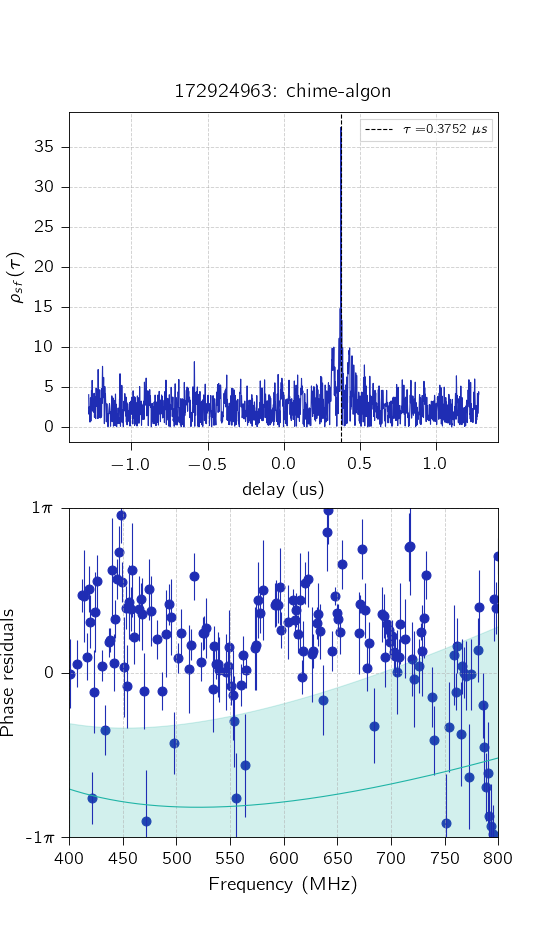

(1024, 1, 2, 2, 300) (1024, 1, 2, 2)
Setting invalid standard dev measurements to : 396.44931356976485
tau= [ 0.37523438  0.37492188  0.64039062 -0.28429688 -0.12203125] (baseline=chime-algon polpair=(1, 0))
0 1 0 tau 0.375234375


/home/calvin/coda/coda/analysis/error_prop.py:113: RuntimeWarning: invalid value encountered in true_divide
  np.abs((on_auto0 * on_auto1) / (off_auto0 * off_auto1)) ** 0.5
/home/calvin/coda/coda/analysis/delay.py:248: RuntimeWarning: invalid value encountered in true_divide
  np.abs(binned_best / binned_best_err) < min_binned_snr,


<IPython.core.display.Javascript object>


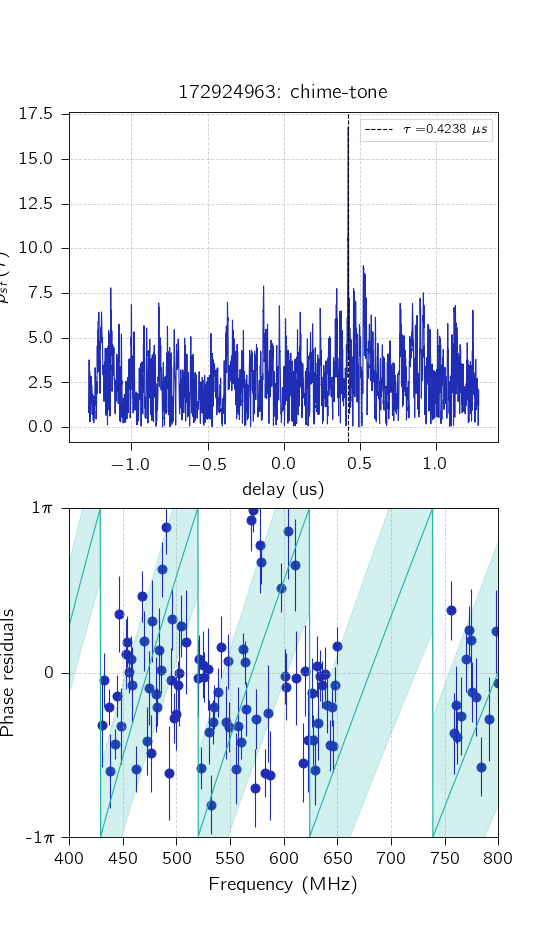

/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/scipy-stack/2022a/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/calvin/coda/coda/analysis/error_prop.py:94: RuntimeWarning: Mean of empty slice
  off_auto0 = avg_func(
/home/calvin/coda/coda/analysis/error_prop.py:113: RuntimeWarning: invalid value encountered in true_divide
  np.abs((on_auto0 * on_auto1) / (off_auto0 * off_auto1)) ** 0.5
/home/calvin/coda/coda/analysis/delay.py:248: RuntimeWarning: invalid value encountered in true_divide
  np.abs(binned_best / binned_best_err) < min_binned_snr,


(1024, 1, 2, 2, 300) (1024, 1, 2, 2)
Setting invalid standard dev measurements to : 1373.0984566856787
tau= [ 0.42375    -1.21226563 -0.73632812 -1.184375    0.29226563] (baseline=chime-tone polpair=(1, 0))
1 1 0 tau 0.42375
Plotting RA,DEC= (10.274068,21.226134)


In [99]:
matplotlib.style.use('/home/calvin/frb-vlbi-loc/plot_scripts/paper_sty.mplstyle')
for crab in [False]:
    if crab: # C3
        vis_file = '/project/rrg-vkaspi-ad/calvin/20210603A-analysis/calibrated_vis/calibrated_173098290_cals_per_baseline_pr_172988231_no_gbo_maser.h5'
        grid_file = '/scratch/calvin/grid_loc_173098290_iono_wide3.h5'
    if not crab: # FRB
        vis_file = '/project/rrg-vkaspi-ad/calvin/20210603A-analysis/calibrated_vis/calibrated_172924963_cals_per_baseline_pr_172988231_no_gbo_maser_flagged.h5'
        grid_file = '/scratch/calvin/grid_loc_172924963_iono_center12.h5'
        
    pr = models.PhaseReferenceNBaseline(
        target_vis=VLBIVis.from_file(
            vis_file),
        delta_dm_width = 5e-8
    )

    bpp_mask = np.ones((2, 2, 2))
    bpp_mask[0, 1, 0] = 0
    bpp_mask[1, 1, 0] = 0
    pr.bpp_mask = bpp_mask  # TODO: add this to reduce_data().
    pr.reduce_data(bpp_mask=bpp_mask, frame_lags=[19, -1], max_snr_per_chan=20)
    pols_to_plot = np.zeros((2, 2, 2))
    pols_to_plot[0, 1, 0] = -1
    pols_to_plot[1, 1, 0] = 1
    pr.bpp_mask = bpp_mask.astype(bool)
    with h5py.File(grid_file,'r') as f:
        grid_max,indices = get_max(f['log_likelihood'])
        params = [f[dim][ii] for ii,dim in zip(indices,['ra','dec','dm0','dm1'])]
        print(params)
        print(grid_max)
        print(f['log_likelihood'][indices])

    axs,tau = pr.overlay_data_model(frame_lags = [19,-1],
                          fscrunch = 4,
                          pols_to_plot = pols_to_plot,
                          params = np.array(params),#np.array([[10.2740685658509, 21.22622365646792, 1.389011764705882e-07, -5.385466666666667e-07]]),
                          data_sign = [-1,1],
                          err_us = [0.0005,0.0005], # 0.5 nanosecond error bar
                         )
    axs[0][1].set_ylabel('Phase residuals')
    axs[1][1].set_ylabel('Phase residuals')
    if crab:
        axs[0][0].get_figure().savefig('/home/calvin/frb-vlbi-loc/figures/model_aro_crab.pdf',dpi = 200)
        axs[1][0].get_figure().savefig('/home/calvin/frb-vlbi-loc/figures/model_tone_crab.pdf',dpi = 200)
    else:
        axs[0][0].get_figure().savefig('/home/calvin/frb-vlbi-loc/figures/model_aro_frb.pdf',dpi = 200)
        axs[1][0].get_figure().savefig('/home/calvin/frb-vlbi-loc/figures/model_tone_frb.pdf',dpi = 200)

Plotting 1 traces with loglikelihood from -1675.4--1675.4


<IPython.core.display.Javascript object>


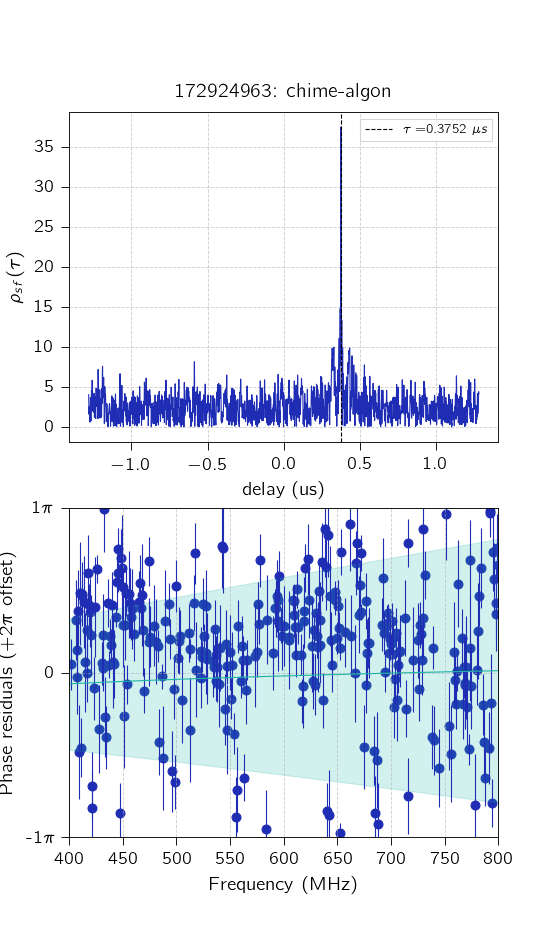

/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/scipy-stack/2022a/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/calvin/coda/coda/analysis/error_prop.py:94: RuntimeWarning: Mean of empty slice
  off_auto0 = avg_func(
/home/calvin/coda/coda/analysis/error_prop.py:113: RuntimeWarning: invalid value encountered in true_divide
  np.abs((on_auto0 * on_auto1) / (off_auto0 * off_auto1)) ** 0.5
/home/calvin/coda/coda/analysis/error_prop.py:100: RuntimeWarning: Mean of empty slice
  off_auto1 = avg_func(
/home/calvin/coda/coda/analysis/delay.py:248: RuntimeWarning: invalid value encountered in true_divide
  np.abs(binned_best / binned_best_err) < min_binned_snr,


(1024, 1, 2, 2, 300) (1024, 1, 2, 2)
Setting invalid standard dev measurements to : 396.44931356976485
tau= [ 0.37523438  0.37492188  0.64039062 -0.28429688 -0.12203125] (baseline=chime-algon polpair=(1, 0))
0 1 0 tau 0.375234375


<IPython.core.display.Javascript object>


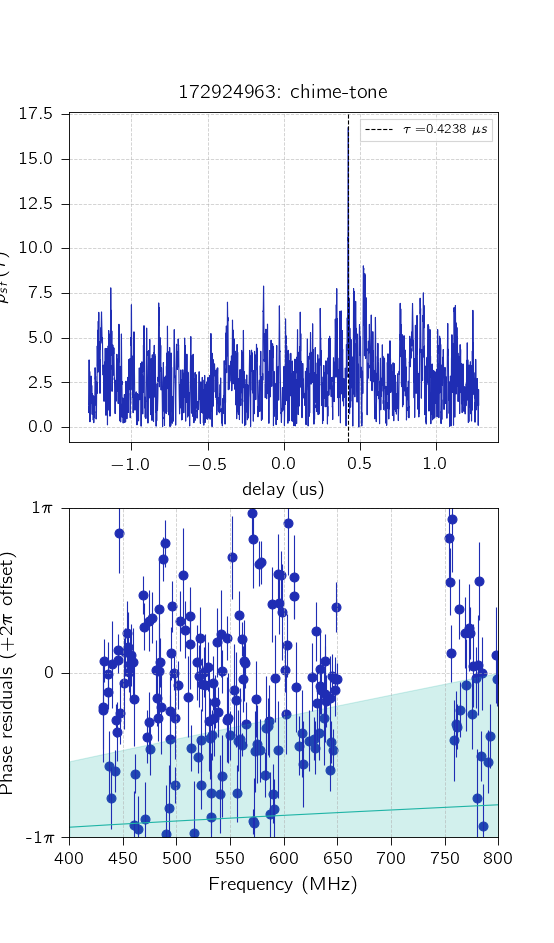

(1024, 1, 2, 2, 300) (1024, 1, 2, 2)
Setting invalid standard dev measurements to : 1373.0984566856787
tau= [ 0.42375    -1.21226563 -0.73632812 -1.184375    0.29226563] (baseline=chime-tone polpair=(1, 0))
1 1 0 tau 0.42375
Plotting RA,DEC= (10.274056,21.226241)


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/scipy-stack/2022a/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/calvin/coda/coda/analysis/error_prop.py:94: RuntimeWarning: Mean of empty slice
  off_auto0 = avg_func(
/home/calvin/coda/coda/analysis/error_prop.py:113: RuntimeWarning: invalid value encountered in true_divide
  np.abs((on_auto0 * on_auto1) / (off_auto0 * off_auto1)) ** 0.5
/home/calvin/coda/coda/analysis/delay.py:248: RuntimeWarning: invalid value encountered in true_divide
  np.abs(binned_best / binned_best_err) < min_binned_snr,


In [101]:
axs, tau = overlay_data_model(pr,
                   frame_lags = [19,-1],
                          fscrunch = 2,
                          pols_to_plot = pols_to_plot,
                          #tau = tau,
                          params = np.array(params_delayonly),
                          data_sign = [-1,1],
                          err_us = [0.0005,0.0005], # 0.5 nanosecond error bar)
                  )

In [109]:
params_delayonly

[10.274056099281554, 21.226241042510203, 0, 0]

In [111]:
pr._log_prob_fn(*np.array(params_delayonly)[:,None])[:,1,0]

array([[-1072.21334741],
       [ -603.15277408]])

In [115]:
params

array([[ 1.02740682e+01,  2.12261344e+01,  1.04785098e-07,
        -2.36375686e-07]])

In [118]:
pr._log_prob_fn(*np.array([ 1.02740682e+01,  2.12261344e+01,  1.04785098e-07,
        -2.36375686e-07])[:,None])[:,1,0]

array([[-757.9547697 ],
       [-691.82130266]])

In [121]:
pr.log_prob_grid_bl

AttributeError: 'PhaseReferenceNBaseline' object has no attribute 'log_prob_grid_bl'

> /tmp/ipykernel_271155/3886059438.py(1)<module>()
----> 1 pr.log_prob_grid_bl

ipdb> q


In [76]:
pr.vis_pr_err_norm[1] *= 1j

In [78]:
pr._log_prob_fn(*np.array(params)[:,None])[:,1,0]

array([[-757.99096006],
       [-692.02361446]])

In [77]:
pr._log_prob_fn(*np.array(params_delayonly)[:,None])[:,1,0]

array([[-1072.21334741],
       [ -615.50464446]])

In [80]:
pr.vis_pr_err_norm[1] /= 1j

Plotting 1 traces with loglikelihood from -1449.7--1449.7


<IPython.core.display.Javascript object>


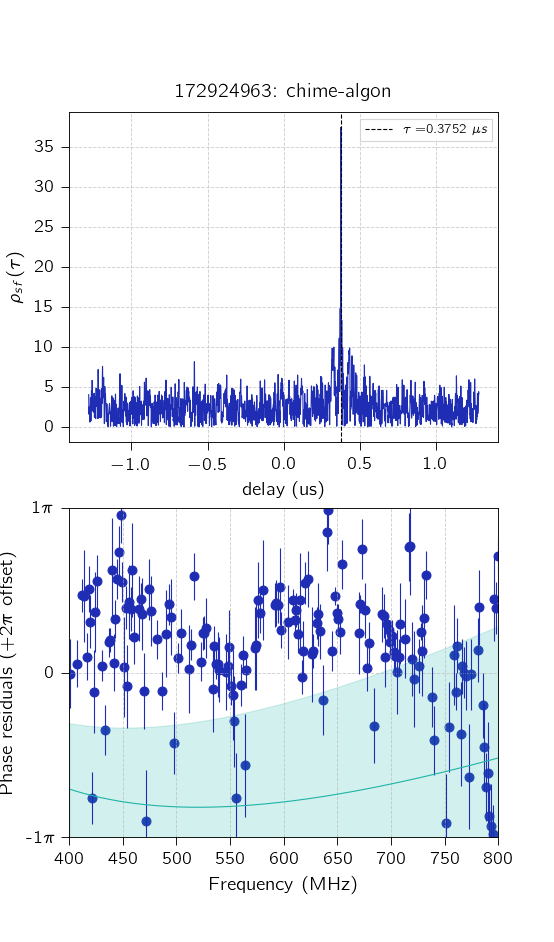

/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/scipy-stack/2022a/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/calvin/coda/coda/analysis/error_prop.py:94: RuntimeWarning: Mean of empty slice
  off_auto0 = avg_func(
/home/calvin/coda/coda/analysis/error_prop.py:113: RuntimeWarning: invalid value encountered in true_divide
  np.abs((on_auto0 * on_auto1) / (off_auto0 * off_auto1)) ** 0.5
/home/calvin/coda/coda/analysis/error_prop.py:100: RuntimeWarning: Mean of empty slice
  off_auto1 = avg_func(
/home/calvin/coda/coda/analysis/delay.py:248: RuntimeWarning: invalid value encountered in true_divide
  np.abs(binned_best / binned_best_err) < min_binned_snr,


(1024, 1, 2, 2, 300) (1024, 1, 2, 2)
Setting invalid standard dev measurements to : 396.44931356976485
tau= [ 0.37523438  0.37492188  0.64039062 -0.28429688 -0.12203125] (baseline=chime-algon polpair=(1, 0))
0 1 0 tau 0.375234375


<IPython.core.display.Javascript object>


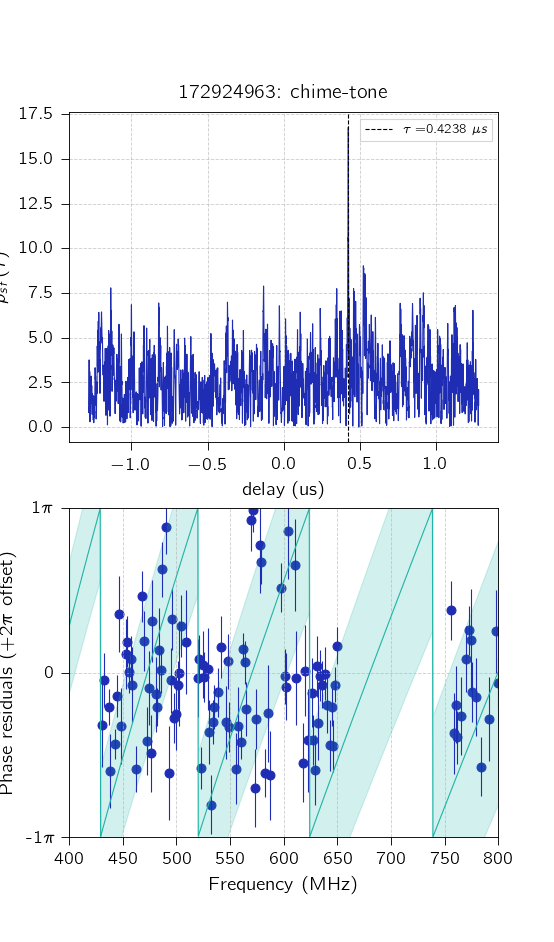

(1024, 1, 2, 2, 300) (1024, 1, 2, 2)
Setting invalid standard dev measurements to : 1373.0984566856787
tau= [ 0.42375    -1.21226563 -0.73632812 -1.184375    0.29226563] (baseline=chime-tone polpair=(1, 0))
1 1 0 tau 0.42375
Plotting RA,DEC= (10.274068,21.226134)


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/scipy-stack/2022a/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/calvin/coda/coda/analysis/error_prop.py:94: RuntimeWarning: Mean of empty slice
  off_auto0 = avg_func(
/home/calvin/coda/coda/analysis/error_prop.py:113: RuntimeWarning: invalid value encountered in true_divide
  np.abs((on_auto0 * on_auto1) / (off_auto0 * off_auto1)) ** 0.5
/home/calvin/coda/coda/analysis/delay.py:248: RuntimeWarning: invalid value encountered in true_divide
  np.abs(binned_best / binned_best_err) < min_binned_snr,


In [102]:
axs, tau = overlay_data_model(pr,
                   frame_lags = [19,-1],
                          fscrunch = 4,
                          pols_to_plot = pols_to_plot,
                          tau = tau,
                          params = np.array(params),
                          data_sign = [-1,1],
                          err_us = [0.0005,0.0005], # 0.5 nanosecond error bar)
                  )

In [103]:
tau[1][0,1,0,0] = 0.429

In [65]:
pols_to_plot[1] *= -1

In [104]:
pols_to_plot[0] *= -1

In [106]:
params = np.array([[10.274068223027372, 21.226134398177425, 1.047850980392156e-07, -2.3637568627450985e-07]])

In [ ]:
10.274068223027372, 21.226134398177425, 1.047850980392156e-07, -2.3637568627450985e-07

Plotting 1 traces with loglikelihood from -1675.4--1675.4


<IPython.core.display.Javascript object>


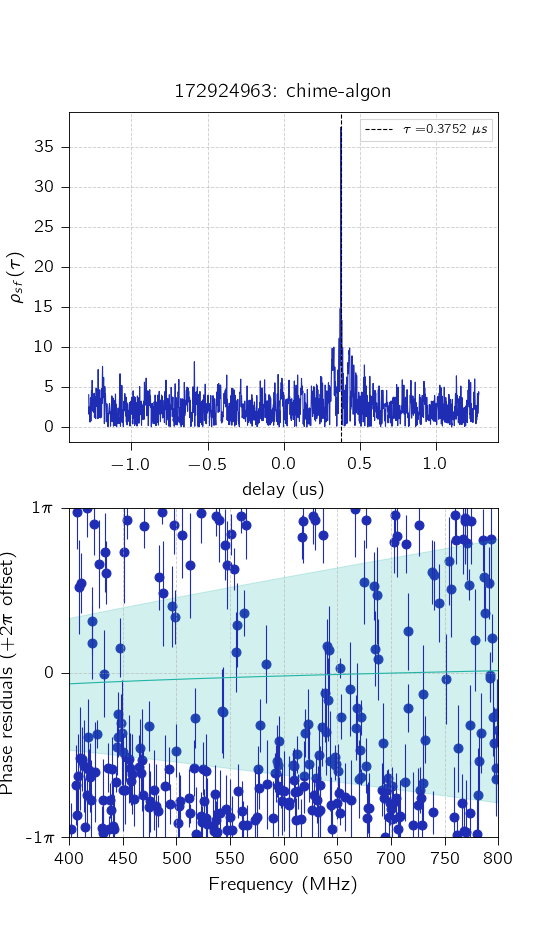

/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/scipy-stack/2022a/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/calvin/coda/coda/analysis/error_prop.py:94: RuntimeWarning: Mean of empty slice
  off_auto0 = avg_func(
/home/calvin/coda/coda/analysis/error_prop.py:113: RuntimeWarning: invalid value encountered in true_divide
  np.abs((on_auto0 * on_auto1) / (off_auto0 * off_auto1)) ** 0.5
/home/calvin/coda/coda/analysis/error_prop.py:100: RuntimeWarning: Mean of empty slice
  off_auto1 = avg_func(
/home/calvin/coda/coda/analysis/delay.py:248: RuntimeWarning: invalid value encountered in true_divide
  np.abs(binned_best / binned_best_err) < min_binned_snr,


(1024, 1, 2, 2, 300) (1024, 1, 2, 2)
Setting invalid standard dev measurements to : 396.44931356976485
tau= [ 0.37523438  0.37492188  0.64039062 -0.28429688 -0.12203125] (baseline=chime-algon polpair=(1, 0))
0 1 0 tau 0.375234375


<IPython.core.display.Javascript object>


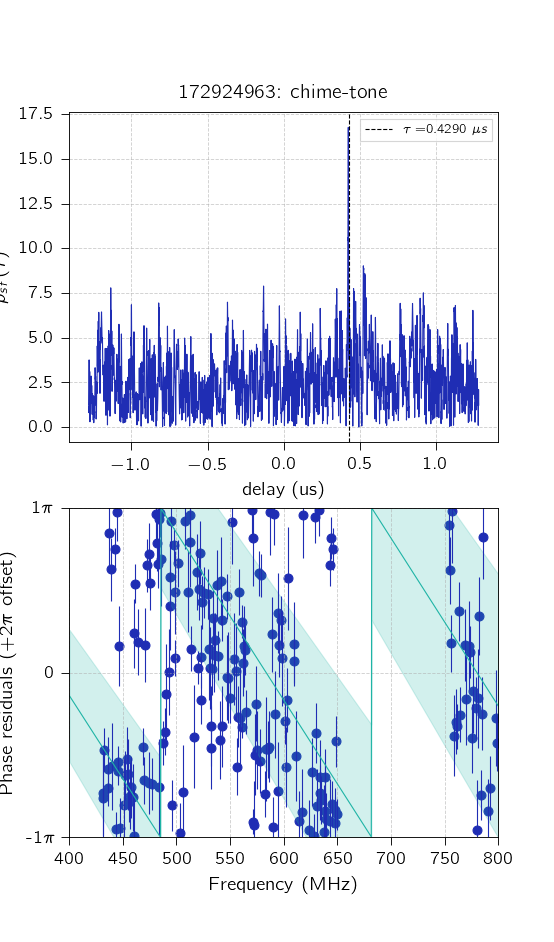

(1024, 1, 2, 2, 300) (1024, 1, 2, 2)
Setting invalid standard dev measurements to : 1373.0984566856787
tau= [ 0.429      -1.21226563 -0.73632812 -1.184375    0.29226563] (baseline=chime-tone polpair=(1, 0))
1 1 0 tau 0.429
Plotting RA,DEC= (10.274056,21.226241)


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/scipy-stack/2022a/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/calvin/coda/coda/analysis/error_prop.py:94: RuntimeWarning: Mean of empty slice
  off_auto0 = avg_func(
/home/calvin/coda/coda/analysis/error_prop.py:113: RuntimeWarning: invalid value encountered in true_divide
  np.abs((on_auto0 * on_auto1) / (off_auto0 * off_auto1)) ** 0.5
/home/calvin/coda/coda/analysis/delay.py:248: RuntimeWarning: invalid value encountered in true_divide
  np.abs(binned_best / binned_best_err) < min_binned_snr,


In [110]:
axs, tau = overlay_data_model(pr,
                   frame_lags = [19,-1],
                          fscrunch = 2,
                          pols_to_plot = pols_to_plot,
                          tau = tau,
                          params = np.array(params_delayonly),
                          data_sign = [1,1],
                          err_us = [0.0005,0.0005], # 0.5 nanosecond error bar)
                  )

In [42]:
params10 = np.array([10.274072868140715, 21.226047575173517, 1.437749019607843e-07, 7.55427450980392e-08])

-1271.9059199622154

In [18]:
from coda.core import math

In [19]:
importlib.reload(delay)

<module 'coda.analysis.delay' from '/home/calvin/coda/coda/analysis/delay.py'>

In [17]:
    def overlay_data_model(
        self,
        frame_lags,
        fscrunch,
        pols_to_plot,
        params=None,
        max_models=50,
        min_binned_snr=1,
        which_window=0,
        which_pointing=0,
        model_sign=None,
        data_sign=None,
        tau=None,
        err_us=None,
        **plot_kwargs,
    ):  
        """
        Overlay the model for the dataset in the space of the data, by plotting many model traces (at most :max_models:) on top of the data.
        This is the most correct thing to do when the model is a good fit to the data (in the chi-squared-per dof ~ 1 sense).
        
        However, the easiest thing to do is to add a timing error of +- err_us to the best-fit model and apply fill_between those. 
        If err_us is passed, such a timing error will be shaded around the best-fit model.

        Parameters
        ----------
        frame_lags : list of ints
            One integer per baseline telling us which frame lag to use.
        which_window : int
            An integer indexing which integration to get data phases from.
        which_pointing : int
            Which pointing to get data phases for
        fscrunch : power of 2
            Frequency downsampling factor. Must divide 1024
        pols_to_plot : np.array
            An array of shape (nbaseline, 2, 2) denoting which polarization to plot. This is checked against self.bpp_mask (used in likelihood calculation) for consistency.
        params : np.array of shape (n_eval, n_dim)
            An array of four floats, representing the RA, DEC, delta DM0, and delta DM1. If an array of shape 
        max_models : int, default 50
            How many model traces to plot at max?
        model_sign : np.ones(nbaseline,)
            Can multiply model phases by a constant factor throughout (usually 1 or -1) to make them line up despite the sign ambiguity.
        data_sign : np.ones(nbaseline,)
            Can multiply data phases by a constant factor throughout (usually 1 or -1) to make them line up with the model despite the sign ambiguity.
        tau : np.array of shape (nbaseline, npointing, npol, npol, ntime), default None
            The amount of delay by which to unwrap the model and the data. If None, coarse_delay will be used to find the best delay.
        err_us : list of length n_baseline; default [np.nan, np.nan,...]
            If not np.nan, will fill_between the last set of model parameters in the params array.
        plot_kwargs : **kwargs
            Keyword arguments for matplotlib.pyplot.plot() when overlaying the model
        """
        if params.ndim == 1:
            params = params[None, :]
        params = params[
            -max_models:
        ]  # make sure params.shape = (n_eval < max_models, n_dim)
        num_models = params.shape[0]  # how many do we plot in the end?
        # Check that we are plotting the right combination of polarizations.
        assert (
            np.sum(np.abs(pols_to_plot), axis=(1, 2)) == np.ones(pols_to_plot.shape[0])
        ).all(), "Only one combination per baseline can be plotted!"
        assert (
            (np.ones(pols_to_plot.shape) - self.bpp_mask) == np.abs(pols_to_plot)
        ).all(), "Conflicting pols_to_plot and self.bpp_mask; pols_to_plot must be +-1 where bpp_mask is 0."

        if model_sign is None:
            model_sign = np.ones(self.target_vis.nbaseline)
        if data_sign is None:
            data_sign = np.ones(self.target_vis.nbaseline)
        if err_us is None:
            err_us = np.nan + np.ones(self.target_vis.nbaseline)
        # Evaluate model and likelihood. Note that in PhaseReferenceNBaseline
        # and DelayOnlyNBaseline, phase_model returns only the phi in
        # exp(2*pi*i*phi).
        model = self.phase_model(
            *(params.T), check=False
        )  # model.shape = (n_baseline, n_freq, n_eval)
        logl = self._log_prob_fn(*(params.T), check=False)
        logl = np.sum(~self.bpp_mask[..., None] * logl, axis=(0, 1, 2))
        # sum over axis=0 (baseline), 1: pol, and 2: pol axesusing bpp_mask
        # index -1 is the maximum likelihood estimate
        iisort = np.argsort(logl)

        # Re-shuffle them
        model = model[:, :, iisort]
        logl = logl[iisort]

        print(
            f"Plotting {num_models} traces with loglikelihood from {np.min(logl):0.1f}-{np.max(logl):0.1f}"
        )
        colors = ["C0", "C1", "C2", "C3"]
        freq = self.target_vis.index_map["freq"]["centre"][:]

        axs = []
        _taus = []

        for iibl, bl in enumerate(self.target_vis.baselines):
            if tau is None: # use coarse_delay to figure out how much unwrapping is needed.
                _tau, _, _ = delay.coarse_delay(bl, frame_lags[iibl], sort = True)
            else:
                _tau = tau[iibl]
            _, _, ax = delay._plot_unwrapped_phases(
                vis_bl=bl,
                frame_lag=frame_lags[iibl],
                fscrunch=fscrunch,
                pols_to_plot=pols_to_plot[iibl],
                tau=_tau,
                min_binned_snr=min_binned_snr,
                axs=None,
            )
            _taus.append(_tau)
            axs.append(ax)
            iiplot = 0
            for jjpol in range(2):
                for kkpol in range(2):
                    if pols_to_plot[iibl, jjpol, kkpol]:
                        print(
                            iibl,
                            jjpol,
                            kkpol,
                            "tau",
                            _tau[which_pointing, jjpol, kkpol, which_window],
                        )
                        for nneval in range(num_models):
                            angles = np.angle(
                                model_sign[iibl]
                                * math.sign_flip(
                                    np.exp(
                                        2j
                                        * np.pi
                                        * ( 
                                            model[iibl, :, nneval]
                                            - freq
                                            * _tau[
                                                which_pointing,
                                                jjpol,
                                                kkpol,
                                                which_window,
                                                None,
                                            ]
                                        )
                                    )
                                )
                            )
                            axs[iibl][1].plot(
                                freq,
                                angles + 2 * iiplot * np.pi,
                                color=colors[jjpol * 2 + kkpol],
                                **plot_kwargs,
                            )
                            if ~np.isnan(err_us[iibl]):
                                phase_err = 2*np.pi*freq*err_us[iibl]
                                axs[iibl][1].fill_between(
                                    freq,
                                    angles + 2 * iiplot * np.pi - phase_err,
                                    angles + 2 * iiplot * np.pi + phase_err,
                                    color=colors[jjpol * 2 + kkpol],
                                    alpha = 0.2,
                                    **plot_kwargs,
                                )
                        iiplot += 1
        param_title = f"Plotting RA,DEC= ({params[0,0]:0.6f},{params[0,1]:0.6f})"
        print(param_title)
        return axs, _taus



Plotting 1 traces with loglikelihood from -1516.8--1516.8


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/scipy-stack/2022a/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/calvin/coda/coda/analysis/error_prop.py:94: RuntimeWarning: Mean of empty slice
  off_auto0 = avg_func(
/home/calvin/coda/coda/analysis/error_prop.py:113: RuntimeWarning: invalid value encountered in true_divide
  np.abs((on_auto0 * on_auto1) / (off_auto0 * off_auto1)) ** 0.5
/home/calvin/coda/coda/analysis/error_prop.py:100: RuntimeWarning: Mean of empty slice
  off_auto1 = avg_func(
/home/calvin/coda/coda/analysis/delay.py:248: RuntimeWarning: invalid value encountered in true_divide
  fscrunch=fscrunch,


(1024, 1, 2, 2, 300) (1024, 1, 2, 2)
Setting invalid standard dev measurements to : 396.44931356976485
tau= [ 0.37523438  0.37492188  0.64039062 -0.28429688 -0.12203125] (baseline=chime-algon polpair=(1, 0))


IndexError: too many indices for array: array is 4-dimensional, but 5 were indexed

> /home/calvin/coda/coda/analysis/models.py(460)overlay_data_model()
    458                             kkpol,
    459                             "tau",
--> 460                             _tau[which_pointing, jjpol, kkpol, which_window],
    461                         )
    462                         for nneval in range(num_models):

ipdb> q


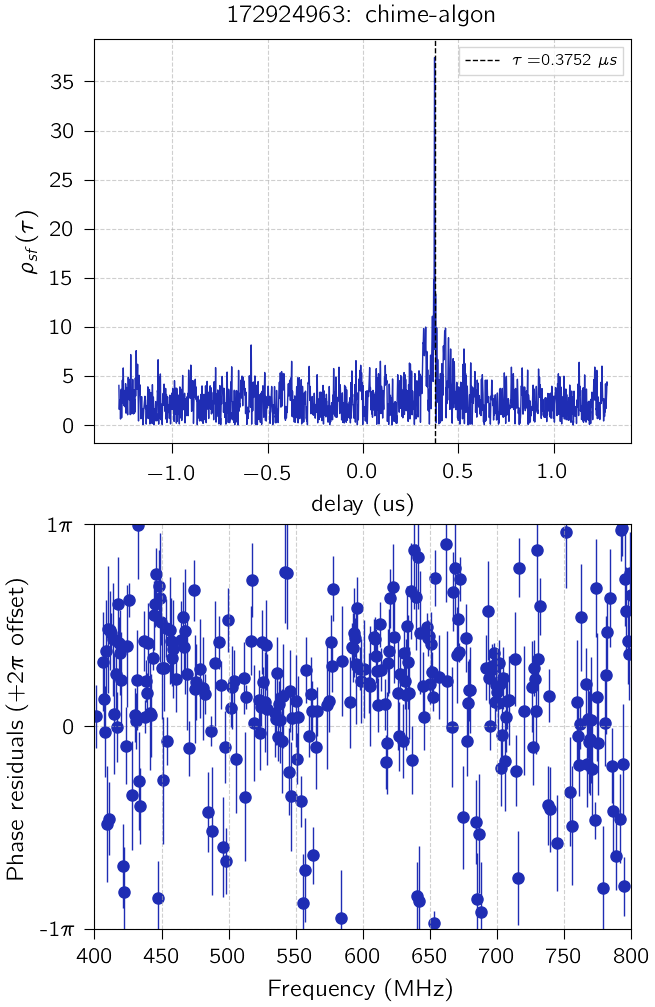

In [24]:
axs,taus = pr.overlay_data_model(frame_lags = [19,-1],
                      fscrunch = 2,
                      pols_to_plot = pols_to_plot,
                      #params = np.array([[10.274073679303227,21.226067778862536, 1.564341781852643e-07, 2.4308576542888334e-08]]),
                      params = np.array([[10.27407375071225, 21.226035849880386, 1.4688395095083904e-07, 1.1504570817675452e-07]]
                                       ),
                      data_sign = [-1,1],
                      err_us = [0.0005,0.0005], # 0.5 nanosecond error bar
                     )
axs[0][1].set_ylabel('Phase residuals')
axs[1][1].set_ylabel('Phase residuals')


In [ ]:
taus[1,:] += 0.01 # Tweak the tau

In [ ]:
axs,taus = pr.overlay_data_model(frame_lags = [19,-1],
                      fscrunch = 2,
                                 tau = taus,
                      pols_to_plot = pols_to_plot,
                      #params = np.array([[10.274073679303227,21.226067778862536, 1.564341781852643e-07, 2.4308576542888334e-08]]),
                      params = np.array([[10.27407375071225, 21.226035849880386, 1.4688395095083904e-07, 1.1504570817675452e-07]]
                                       ),
                      data_sign = [-1,1],
                      err_us = [0.0005,0.0005], # 0.5 nanosecond error bar
                     )
axs[0][1].set_ylabel('Phase residuals')
axs[1][1].set_ylabel('Phase residuals')


In [20]:
params

[10.2740685658509,
 21.22622365646792,
 1.389011764705882e-07,
 -5.385466666666667e-07]

In [24]:
pols_to_plot[0,1,0] = 1

In [34]:
pr.target_vis['chime-tone']['vis'].attrs['tec_correction']

-2.9329329329329313e-07

In [11]:
axs = pr.overlay_data_model(frame_lags = [19,-1],
                      fscrunch = 4,
                      pols_to_plot = pols_to_plot,
                      params = np.array([[10.2740685658509, 21.22622365646792, 1.389011764705882e-07, -5.385466666666667e-07]]),
                      data_sign = [-1,1],
                      err_us = [0.0005,0.0005], # 0.5 nanosecond error bar
                     )


NameError: name 'pr' is not defined

In [12]:
from coda.core import flagging

In [162]:
    pr.reduce_data(bpp_mask=bpp_mask, frame_lags=[19, -1], max_snr_per_chan=20)


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/scipy-stack/2022a/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/calvin/coda/coda/analysis/error_prop.py:94: RuntimeWarning: Mean of empty slice
  off_auto0 = avg_func(
/home/calvin/coda/coda/analysis/error_prop.py:100: RuntimeWarning: Mean of empty slice
  off_auto1 = avg_func(


(1024, 1, 2, 2, 300) (1024, 1, 2, 2)
Setting invalid standard dev measurements to : 325.55157470703125
[-2921.42500473 -2921.42500473 -2921.42712379 ... -2927.86617543
 -2927.8829609  -2927.89979777]


/home/calvin/coda/coda/analysis/models.py:1568: RuntimeWarning: invalid value encountered in true_divide
  ~channel_mask[bl.name[1:]][:, None, None] * target_phase / target_std


(1024, 1, 2, 2, 300) (1024, 1, 2, 2)
Setting invalid standard dev measurements to : 1223.8736572265625
[-2052.90386625 -2052.90386625 -2052.90616862 ... -2059.9027355
 -2059.92097546 -2059.93927127]


In [138]:
params

[10.27406707941463,
 21.226278932849826,
 1.389011764705882e-07,
 3.046078431372548e-07]

In [186]:
pols_to_plot[0,1,0] *= -1

In [9]:
pols_to_plot

NameError: name 'pols_to_plot' is not defined

> /tmp/ipykernel_179899/1633740366.py(1)<module>()
----> 1 pols_to_plot

ipdb> q


Plotting 1 traces with loglikelihood from -1649.1--1649.1


<IPython.core.display.Javascript object>


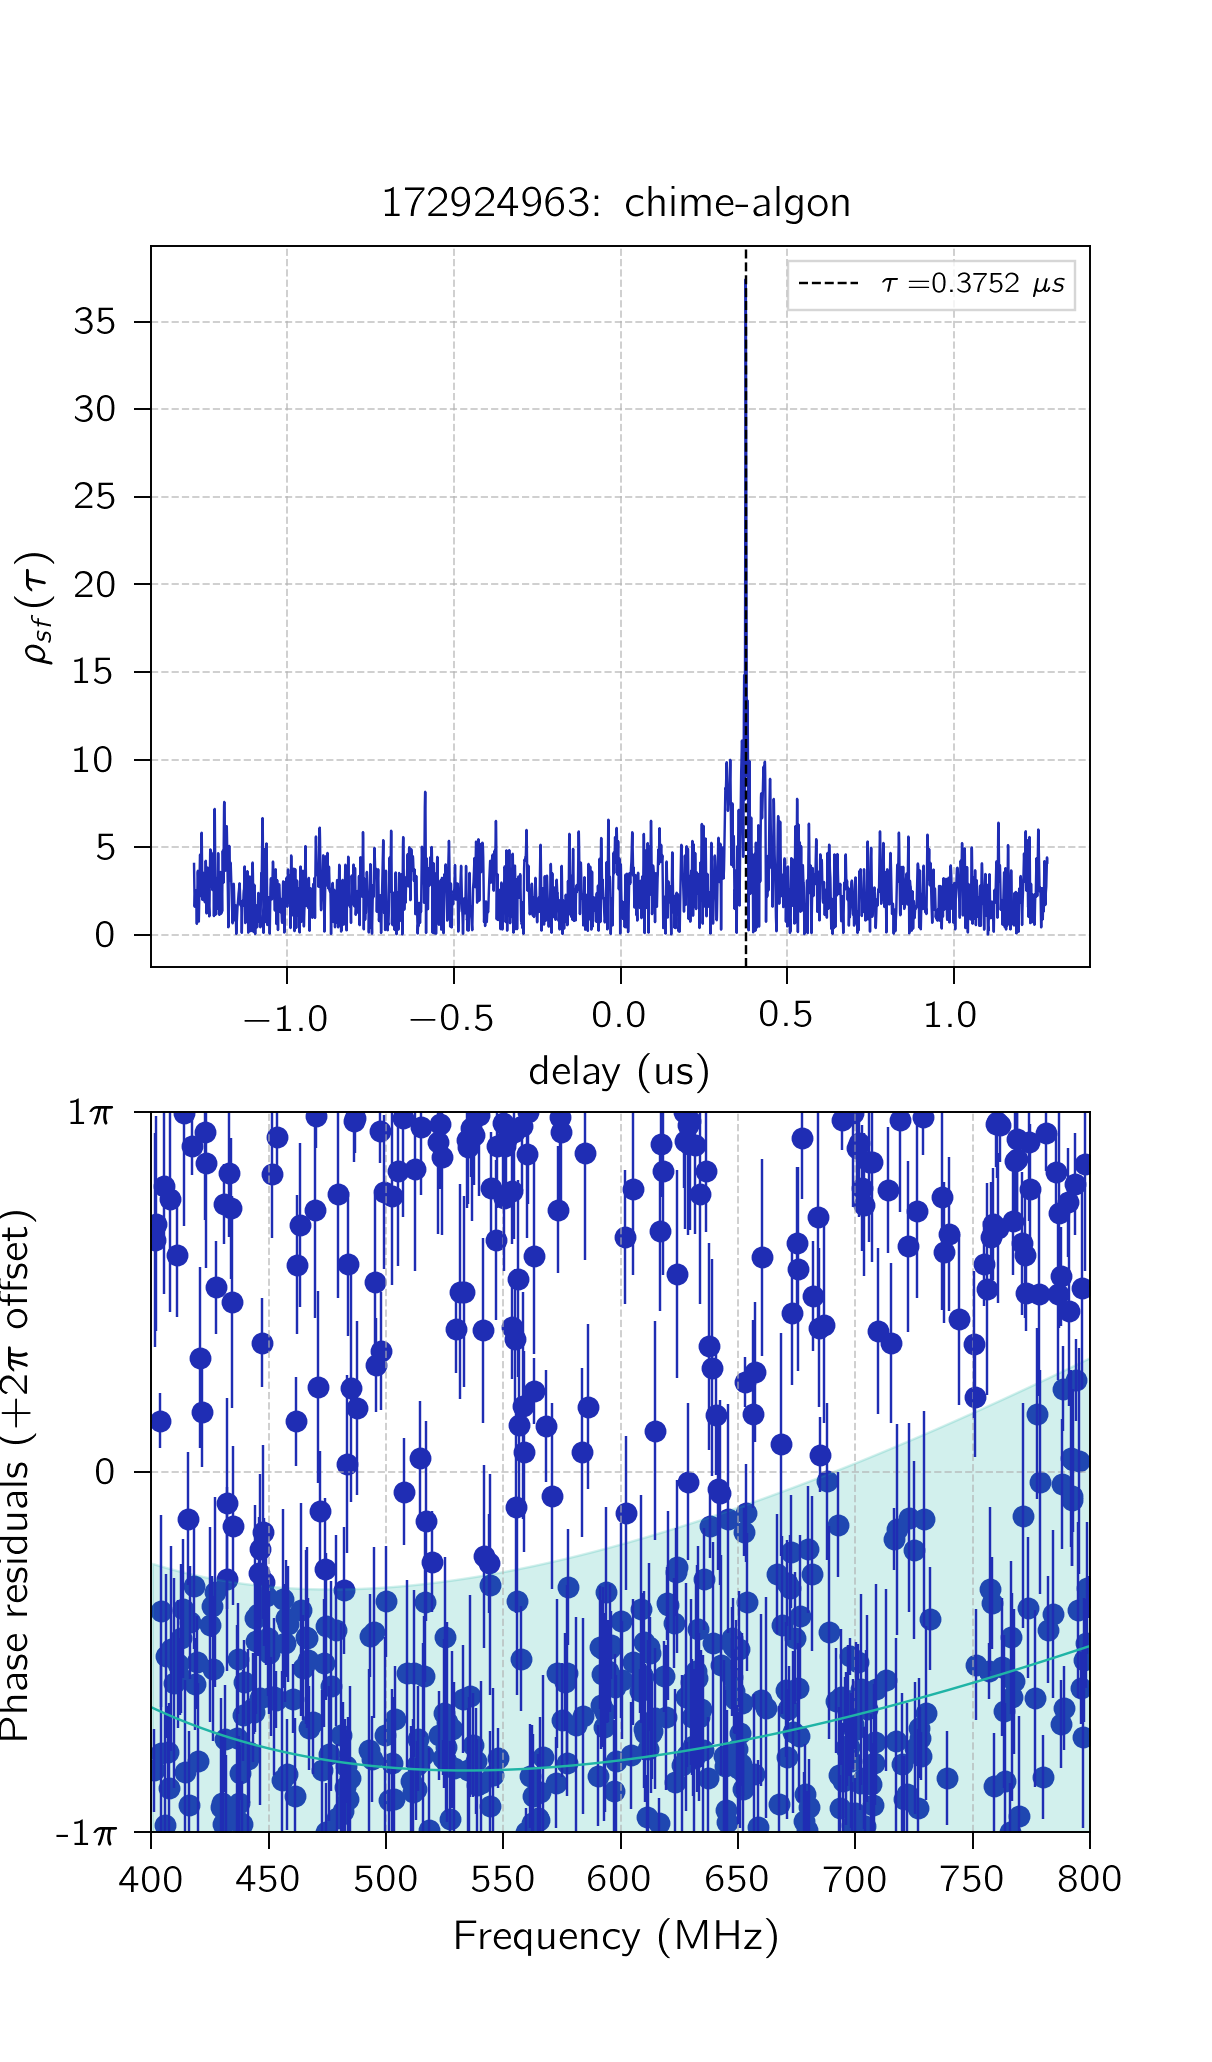

/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/scipy-stack/2022a/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/calvin/coda/coda/analysis/error_prop.py:94: RuntimeWarning: Mean of empty slice
  off_auto0 = avg_func(
/home/calvin/coda/coda/analysis/error_prop.py:113: RuntimeWarning: invalid value encountered in true_divide
  np.abs((on_auto0 * on_auto1) / (off_auto0 * off_auto1)) ** 0.5
/home/calvin/coda/coda/analysis/error_prop.py:100: RuntimeWarning: Mean of empty slice
  off_auto1 = avg_func(
/home/calvin/coda/coda/analysis/delay.py:253: RuntimeWarning: invalid value encountered in true_divide
  np.abs(binned_best / binned_best_err) < min_binned_snr,


(1024, 1, 2, 2, 300) (1024, 1, 2, 2)
Setting invalid standard dev measurements to : 396.44931356976485
tau= [ 0.37523438  0.37492188  0.64039062 -0.28429688 -0.12203125] (baseline=chime-algon polpair=(1, 0))
0 1 0 tau 0.375234375


<IPython.core.display.Javascript object>


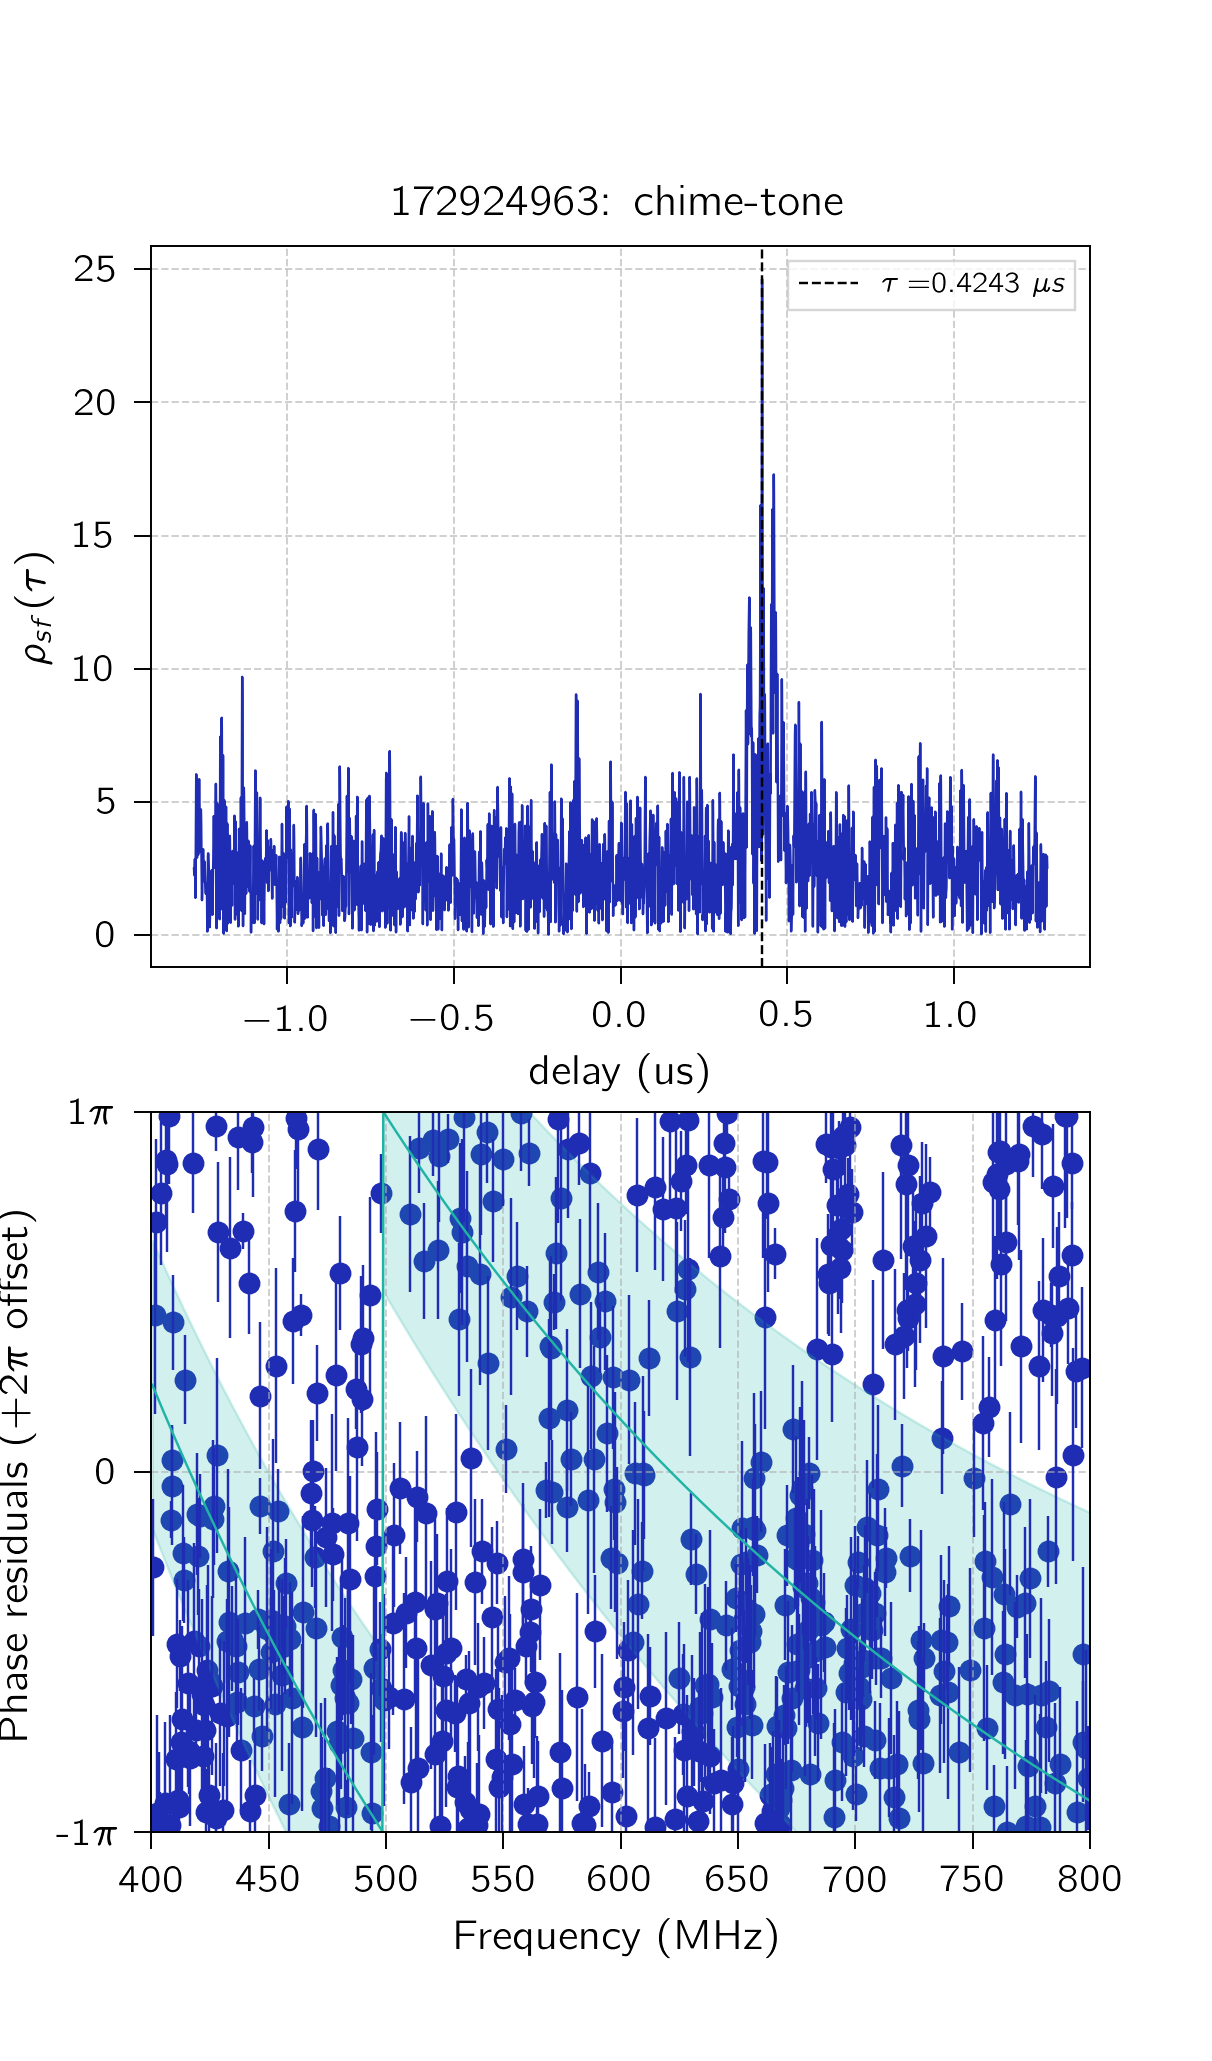

(1024, 1, 2, 2, 300) (1024, 1, 2, 2)
Setting invalid standard dev measurements to : 1491.9393750959061
tau= [ 0.42429688  0.42515625  0.2334375  -0.0425      0.291875  ] (baseline=chime-tone polpair=(1, 0))
1 1 0 tau 0.424296875
Plotting RA,DEC= (10.274067,21.226279)


/cvmfs/soft.computecanada.ca/easybuild/software/2020/avx2/Core/scipy-stack/2022a/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/calvin/coda/coda/analysis/error_prop.py:94: RuntimeWarning: Mean of empty slice
  off_auto0 = avg_func(
/home/calvin/coda/coda/analysis/error_prop.py:113: RuntimeWarning: invalid value encountered in true_divide
  np.abs((on_auto0 * on_auto1) / (off_auto0 * off_auto1)) ** 0.5
/home/calvin/coda/coda/analysis/delay.py:253: RuntimeWarning: invalid value encountered in true_divide
  np.abs(binned_best / binned_best_err) < min_binned_snr,


In [187]:

    axs = pr.overlay_data_model(frame_lags = [19,-1],
                          fscrunch = 1,
                          pols_to_plot = pols_to_plot,
                          params = np.array([
                                 10.27406707941463,
                                 21.226278932849826,
                                 1.389011764705882e-07,
                                 3.046078431372548e-07
                          ]),
                          data_sign = [1,1],
                          err_us = [0.0005,0.0005], # 0.5 nanosecond error bar
                               )

In [ ]:
    pols_to_plot = np.zeros((2, 2, 2))
    pols_to_plot[0, 1, 0] = 1
    pols_to_plot[1, 1, 0] = 1

In [ ]:
params = np.array([10.27406707941463, 21.226278932849826, 1.389011764705882e-07, 0])
axs = pr.overlay_data_model(frame_lags = [19,-1],
                      fscrunch = 4,
                      pols_to_plot = pols_to_plot,
                      params = np.array(params),
                      data_sign = [-1,-1],
                      err_us = [0.0005,0.0005], # 0.5 nanosecond error bar
                     )
axs[0][1].set_ylabel('Phase residuals')
axs[1][1].set_ylabel('Phase residuals')

In [ ]:
with h5py.File('/scratch/calvin/grid_loc_173098290_iono_fine_concat.h5',mode = 'r') as f:
    print(get_max(f['log_likelihood']))
    print(get_min(f['log_likelihood']))
    ra_grid = f['ra'][:]
    peak = get_max(f['log_likelihood'])
    print(peak)
    p = get_prob_ra_dec(f['log_likelihood'])

In [ ]:
# Get best parameter set out of the grid.
truths = [83.6330379265521,22.01450181982256,0,0]

for grid_run in [#'/scratch/calvin/multiproc_c3_loc.h5',
                #'/scratch/calvin/loc_iono_173098290.h5',
                #'/scratch/calvin/loc_iono_173098290_fine.h5',
                 #'/scratch/calvin/grid_loc_test_32.h5',
                 #'/scratch/calvin/grid_loc_173098290_200_200_128_128.h5',
                 #'scratch/grid_loc_173098290_2_iono_concat.h5'
                #'scratch/grid_loc_173098290_test_iono_concat.h5',
                #'scratch/grid_loc_173098290_2_iono_concat.h5',
                #'/scratch/calvin/crab_grids/grid_loc_173098290_iono_fine_concat.h5',
                #'/project/rrg-vkaspi-ad/calvin/20210603A-analysis/successful_grids/grid_loc_173098290_iono_centered_concat.h5', 
                #'/scratch/calvin/grid_loc_173098290_iono_fine_concat.h5',
                #'/project/rrg-vkaspi-ad/calvin/20210603A-analysis/successful_grids/grid_loc_173098290_iono_wide.h5',
                #'/scratch/calvin/grid_loc_173098290_iono_wide.h5'
                #'/project/rrg-vkaspi-ad/calvin/20210603A-analysis/successful_grids/grid_loc_172924963_iono_center3_concat.h5',
                #'/project/rrg-vkaspi-ad/calvin/20210603A-analysis/successful_grids/grid_loc_172924963_iono_center3_concat.h5'
                #'/scratch/calvin/grid_loc_172924963_iono_center4.h5'
                '/scratch/calvin/grid_loc_173098290_iono_fine_concat.h5'
                ]:
    f = h5py.File(grid_run,mode = 'r')
    print(list(f.keys()))
    print(np.max(f['dm0']))
    print(np.max(f['dm1']))

    prob_ra_dec = get_prob_ra_dec(f['log_likelihood'])
    prob_ra_dec /= np.sum(prob_ra_dec)
    prob_dm_dm = get_prob_dm_dm(f['log_likelihood'])
    prob_dm_dm /= np.sum(prob_dm_dm)
    print('<p O> / <p> :',np.sum(f['ra'][:][:,None] * prob_ra_dec),
                          np.sum(f['dec'][:][None,:] * prob_ra_dec),
                          np.sum(f['dm0'][:][:,None] * prob_dm_dm),
                          np.sum(f['dm1'][:][None,:] * prob_dm_dm))
    #print('Grid-max Likelihood :',f['ra'][iimax[0]],f['dec'][iimax[1]],f['dm0'][iimax[2]],f['dm1'][iimax[3]])
    R,D = np.meshgrid(f['ra'][:],f['dec'][:],indexing='ij')
    DM0,DM1 = np.meshgrid(f['dm0'][:],f['dm1'][:],indexing = 'ij')
    
    plt.figure()
    plt.title('Probability')
    plt.xlabel('ra (deg)')
    plt.ylabel('dec (deg)')
    #plt.axhline(dec_max)
    #plt.axvline(ra_max)
    plt.contourf(R,D,prob_ra_dec)
    plt.colorbar()
    #plt.scatter([83.6330379265521],[22.01450181982256],marker = '*',label = 'True Crgrid_loc_172924963_iono_center3_concat.h5ab position',color = 'red')


    plt.figure()
    plt.title('Log10(Probability)')
    plt.xlabel('ra (deg)')
    plt.ylabel('dec (deg)')
    plt.contour(R,D,np.log10(prob_ra_dec),levels = np.linspace(-6,0,num=5))
    plt.colorbar()
    #plt.axhline(dec_max)
    #plt.axvline(ra_max)
    #plt.scatter([83.6330379265521],[22.01450181982256],marker = '*',label = 'True Crab position',color = 'red')
    
    
    plt.figure()
    plt.title('Log10(Probability)')
    plt.xlabel('DM0 (pc cm-3)')
    plt.ylabel('DM1 (pc cm-3)')
    plt.contour(DM0,DM1,np.log10(prob_dm_dm),levels = np.linspace(-4,0,num=5))
    plt.colorbar()
    

# Corner Plot

In [14]:
from coda.core import VLBIVis

In [16]:
crab = False
if crab:
    vis_file = '/project/rrg-vkaspi-ad/calvin/20210603A-analysis/calibrated_vis/calibrated_173098290_cals_per_baseline_pr_172988231_no_gbo_maser.h5'
    grid_file = '/project/rrg-vkaspi-ad/calvin/20210603A-analysis/successful_grids/grid_loc_173098290_iono_wide2.h5'
    
else:
    vis_file = '/project/rrg-vkaspi-ad/calvin/20210603A-analysis/calibrated_vis/calibrated_172924963_cals_per_baseline_pr_172988231_no_gbo_maser.h5'
    grid_file = '/project/rrg-vkaspi-ad/calvin/20210603A-analysis/successful_grids/grid_loc_172924963_iono_center9.h5'

target_vis=VLBIVis.from_file(vis_file)
print(target_vis['chime-algon']['vis'].attrs['tec_correction'])
print(target_vis['chime-tone']['vis'].attrs['tec_correction'])

-1.73173173173173e-07
-2.9329329329329313e-07


# Marginalize, then Plot

# Tools for corner plots

In [79]:

def set_labels(fig):
    axs = fig.axes
    ndim = int(np.sqrt(len(axs)))
    for ii in range(ndim):
        for jj in range(ndim):
            # ii is row, jj is column
            if ii != 0 and jj == 0: # left row
                #axs[ndim*ii+jj].set_ylabel(ax_labels[ii])
                if ii == 1:
                    plt.setp(axs[ndim*ii+jj].get_yticklabels()[0], visible=False) # remove first tick labels

                if ii >= ndim - 2: # DM axes
                    ticks_y = FuncFormatter(lambda x, pos: '{0:g}'.format(x/1e-7))
                    axs[ndim*ii+jj].yaxis.set_major_formatter(ticks_y)


                #axs[ndim*ii+jj].yaxis.set_major_locator(MaxNLocator(4,prune='both'))
            if ii == ndim-1 : # bottom row
                if jj == 1:
                    plt.setp(axs[ndim*ii+jj].get_xticklabels()[0], visible=False) # remove tick labels
                #axs[ndim*ii+jj].set_xlabel(ax_labels[jj])
                if jj >= ndim - 2: # DM axes
                    ticks_x = FuncFormatter(lambda x, pos: '{0:g}'.format(x/1e-7))
                    axs[ndim*ii+jj].xaxis.set_major_formatter(ticks_x)
                #axs[ndim*ii+jj].xaxis.set_major_locator(MaxNLocator(4,prune='both'))
def set_ticks_invisible(fig):
    axs = fig.axes
    ndim = int(np.sqrt(len(axs)))
    for ii in range(ndim):
        for jj in range(ndim):
            # ii is row, jj is column
            if jj > 0:
                axs[ndim*ii+jj].axes.yaxis.set_ticklabels([])
            if ii < ndim-1:
                axs[ndim*ii+jj].axes.xaxis.set_ticklabels([])


In [15]:
# Marginalize

with h5py.File('/scratch/calvin/grid_loc_172924963_iono_center10.h5') as f:
    #Start at the top left and work your way down.
    peak,ind = get_max(f['log_likelihood'])
    p_01 = get_prob_ra_dec( f['log_likelihood'],peak = peak)
    p_02 = get_prob_ra_dm0( f['log_likelihood'],peak = peak)
    p_03 = get_prob_ra_dm1( f['log_likelihood'],peak = peak)
    print('done')
    p_12 = get_prob_dec_dm0(f['log_likelihood'],peak = peak)
    print('done')
    p_13 = get_prob_dec_dm1(f['log_likelihood'],peak = peak)
    print('done')
    p_23 = get_prob_dm_dm(f['log_likelihood'],peak = peak)
    p_0 = np.sum(p_01,axis = 1)
    p_1 = np.sum(p_01,axis = 0)
    p_2 = np.sum(p_23,axis = -1)
    p_3 = np.sum(p_23,axis = 0)
    p_0 /= np.max(p_0)
    p_1 /= np.max(p_1)
    p_2 /= np.max(p_2)
    p_3 /= np.max(p_3)
    
    print('done precomputing,start plotting')

#     R,DM0 = np.meshgrid(f['ra'][:],f['dm0'][:],indexing='ij')
#     plt.contourf(R,DM0,p_02)
    



Processing 0/30
Processing 1/30
Processing 2/30
Processing 3/30
Processing 4/30
Processing 5/30
Processing 6/30
Processing 7/30
Processing 8/30
Processing 9/30
Processing 10/30
Processing 11/30
Processing 12/30
Processing 13/30
Processing 14/30
Processing 15/30
Processing 16/30
Processing 17/30
Processing 18/30
Processing 19/30
Processing 20/30
Processing 21/30
Processing 22/30
Processing 23/30
Processing 24/30
Processing 25/30
Processing 26/30
Processing 27/30
Processing 28/30
Processing 29/30
Using maximum value of peak = {peak}
Processing 0/30
Processing 1/30
Processing 2/30
Processing 3/30
Processing 4/30
Processing 5/30
Processing 6/30
Processing 7/30
Processing 8/30
Processing 9/30
Processing 10/30
Processing 11/30
Processing 12/30
Processing 13/30
Processing 14/30
Processing 15/30
Processing 16/30
Processing 17/30
Processing 18/30
Processing 19/30
Processing 20/30
Processing 21/30
Processing 22/30
Processing 23/30
Processing 24/30
Processing 25/30
Processing 26/30
Processing 27/

IndexError: Index (30) out of range for (0-29)

In [21]:
%matplotlib notebook

<IPython.core.display.Javascript object>


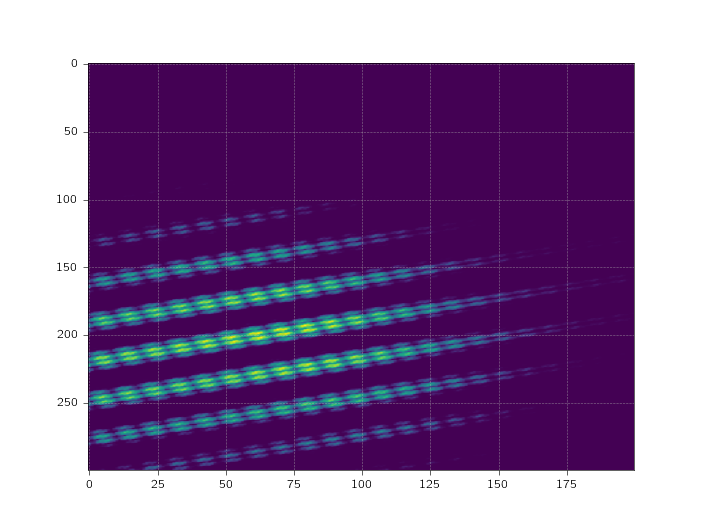

<IPython.core.display.Javascript object>


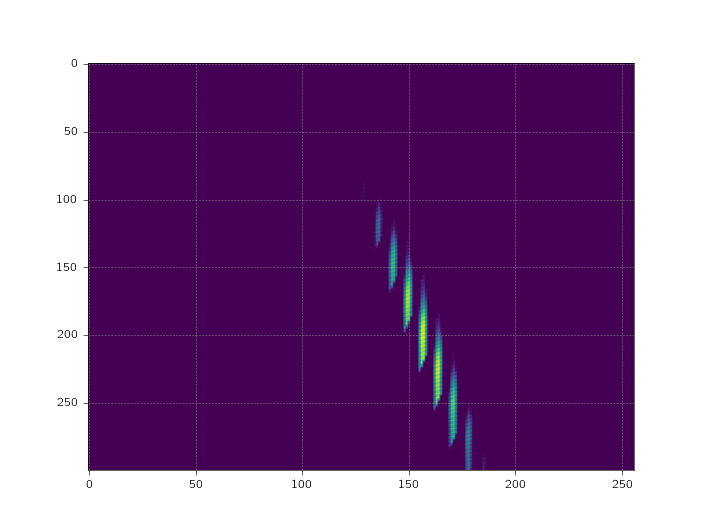

<IPython.core.display.Javascript object>


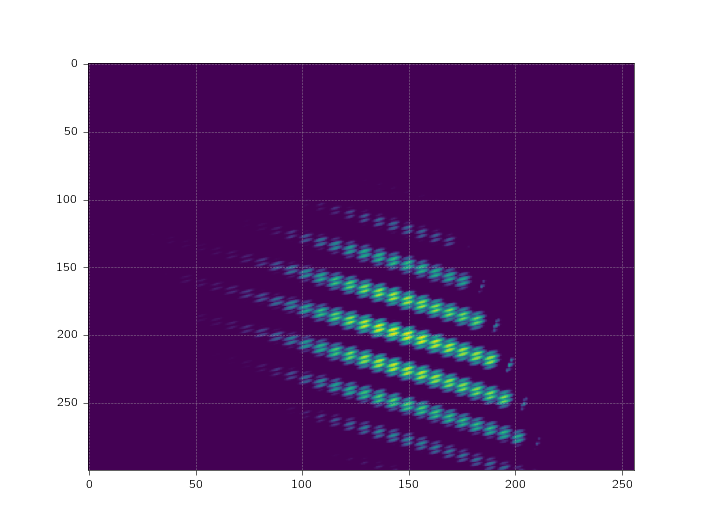

<IPython.core.display.Javascript object>


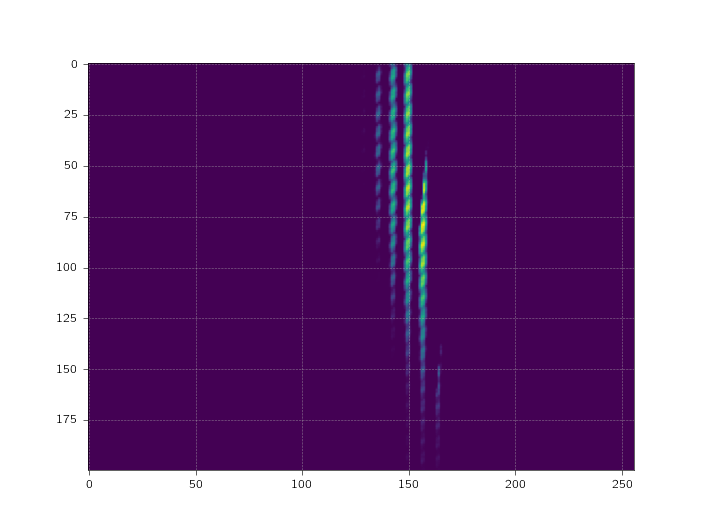

<IPython.core.display.Javascript object>


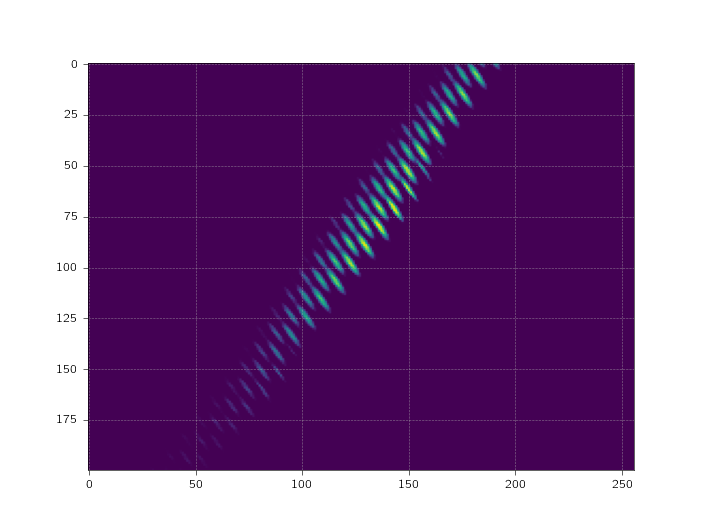

<IPython.core.display.Javascript object>


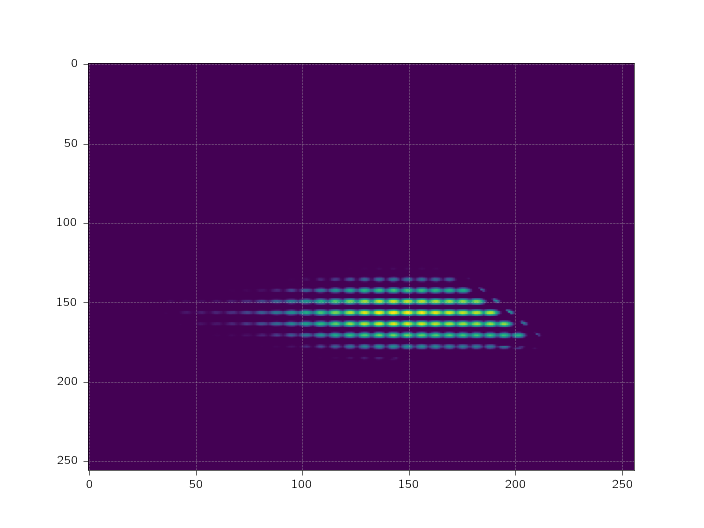

In [22]:
plt.figure()
plt.imshow(np.log10(p_01 + 1e-6))
plt.figure()
plt.imshow(np.log10(p_02 + 1e-6))
plt.figure()
plt.imshow(np.log10(p_03 + 1e-6))
plt.figure()
plt.imshow(np.log10(p_12 + 1e-6))
plt.figure()
plt.imshow(np.log10(p_13 + 1e-6))
plt.figure()
plt.imshow(np.log10(p_23 + 1e-6))

In [23]:
from corner import corner

In [24]:
%matplotlib notebook

In [47]:
target_vis = VLBIVis.from_file('/project/rrg-vkaspi-ad/calvin/20210603A-analysis/calibrated_vis/calibrated_172924963_cals_per_baseline_pr_172988231_no_gbo_maser_flagged.h5')

<IPython.core.display.Javascript object>


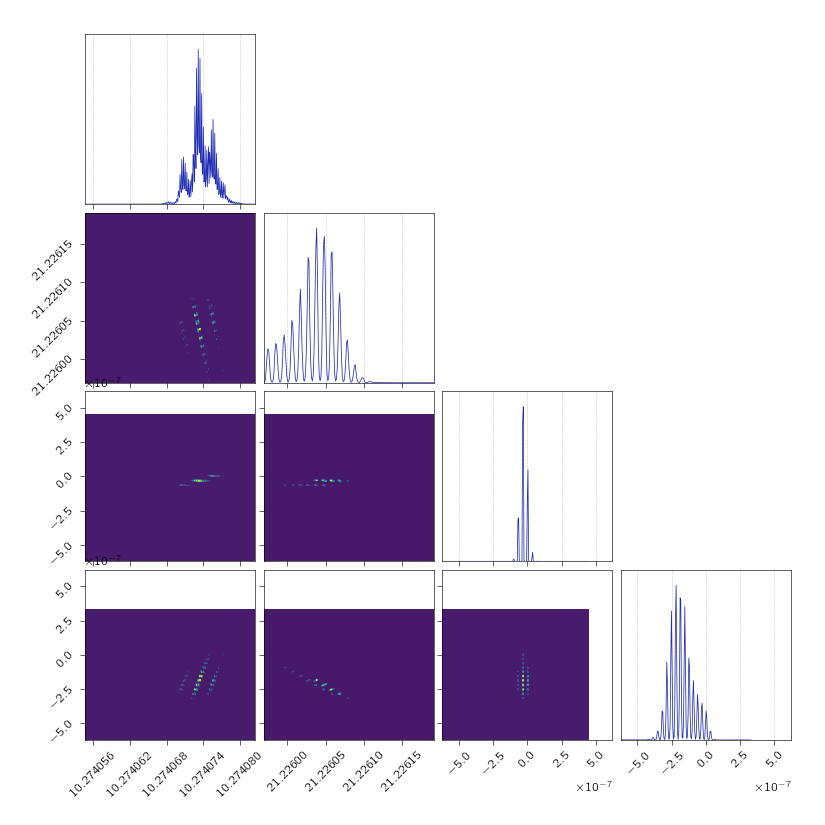

In [25]:
cov_fig,_ = plt.subplots(figsize = (7.5,7.5),nrows = 4, ncols = 4)
dm0_removed = pr.target_vis['chime-algon']['vis'].attrs['tec_correction']
dm1_removed = pr.target_vis['chime-tone']['vis'].attrs['tec_correction']

with h5py.File('/scratch/calvin/grid_loc_172924963_iono_center9.h5') as f:    
    dm0 = f['dm0'][:] + dm0_removed
    dm1 = f['dm1'][:] + dm1_removed
    data = np.vstack([f['ra'][0:4],f['dec'][0:4],f['dm0'][0:4],f['dm1'][0:4]]).T # hack corner.py to give a fig
    corner(data,hist_kwargs={'alpha':0},fig = cov_fig) # hide histograms LOL
    lim_list = [[f[k][0],f[k][-1]] for k in ['ra','dec','dm0','dm1']]
    set_lim(cov_fig,lim_list,axis = 'x')
    set_lim(cov_fig,lim_list,axis = 'y')

    # ra
    cov_fig.axes[0].plot(f['ra'][:],p_0)    
    R,D = np.meshgrid(f['ra'][:],f['dec'][:],indexing='ij')
    
    # ra dec
    cov_fig.axes[4].contourf(R,D,p_01)

    # ra dm0
    R,DM0 = np.meshgrid(f['ra'][:],dm0,indexing='ij')
    cov_fig.axes[8].contourf(R,DM0,p_02)
    # ra dm1
    R,DM1 = np.meshgrid(f['ra'][:],dm1,indexing='ij')
    cov_fig.axes[12].contourf(R,DM1,p_03)
    
    # dec
    cov_fig.axes[5].plot(f['dec'][:],p_1)
        
    # dec dm0
    D,DM0 = np.meshgrid(f['dec'][:],dm0,indexing='ij')
    cov_fig.axes[9].contourf(D, DM0, p_12)
    
    # dec dm1
    D,DM1 = np.meshgrid(f['dec'][:],dm1,indexing='ij')
    cov_fig.axes[13].contourf(D, DM1, p_13)
    
    # dm0
    cov_fig.axes[10].plot(dm0,p_2)
    
    # dm0 dm1
    DM0, DM1 = np.meshgrid(dm0,dm1,indexing='ij')
    cov_fig.axes[14].contourf(DM0,DM1,p_23)

    # dm1
    cov_fig.axes[15].plot(dm1,p_3)
set_ticks_invisible(cov_fig)


<IPython.core.display.Javascript object>


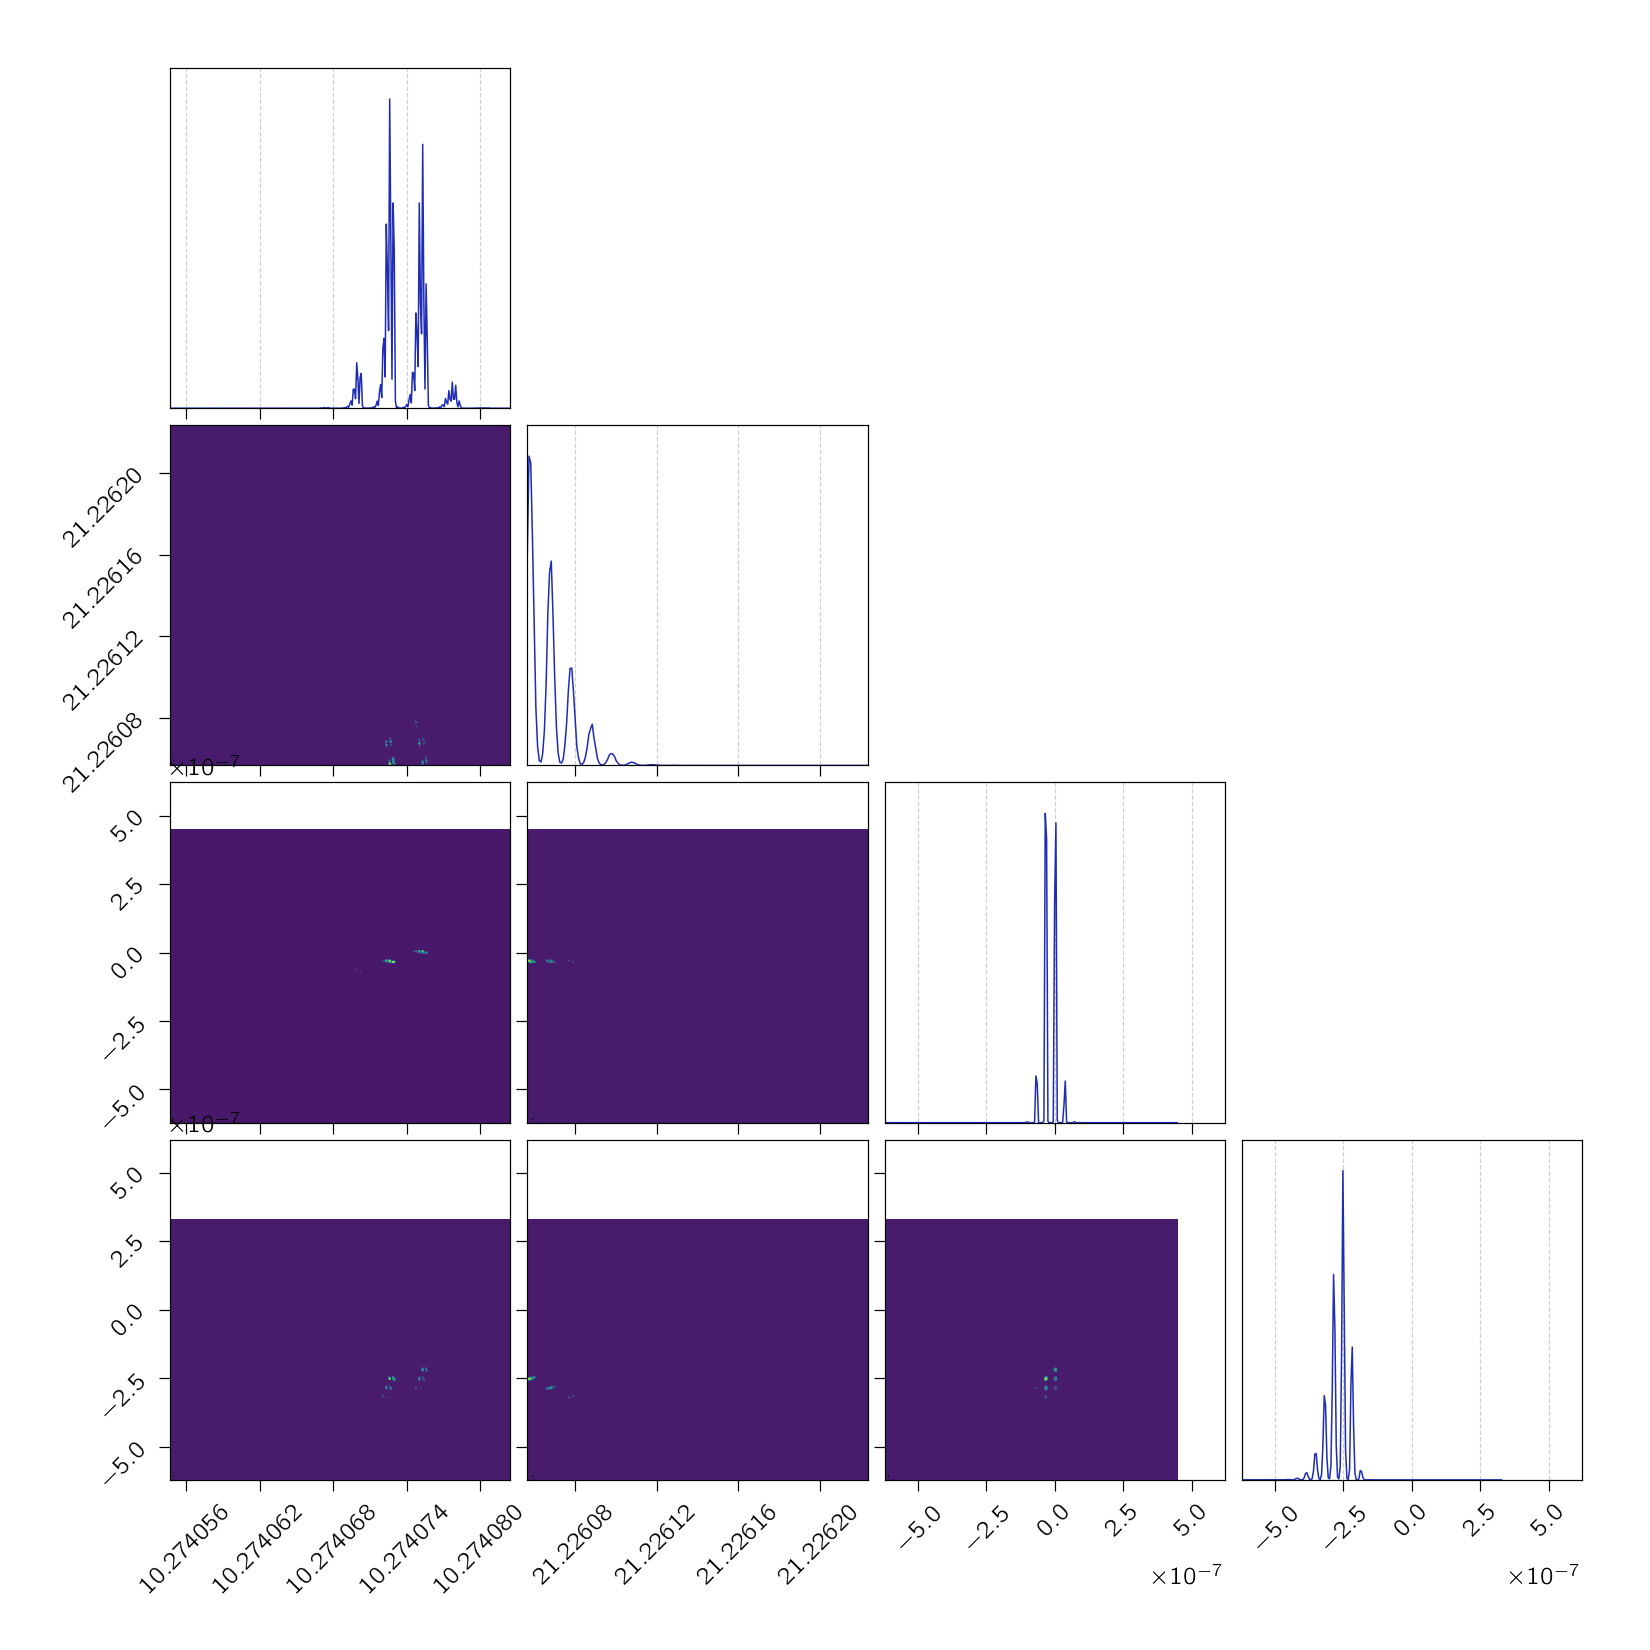

In [48]:
cov_fig,_ = plt.subplots(figsize = (7.5,7.5),nrows = 4, ncols = 4)
dm0_removed = target_vis['chime-algon']['vis'].attrs['tec_correction']
dm1_removed = target_vis['chime-tone']['vis'].attrs['tec_correction']

with h5py.File('/scratch/calvin/grid_loc_172924963_iono_center8.h5') as f:    
    dm0 = f['dm0'][:] + dm0_removed
    dm1 = f['dm1'][:] + dm1_removed
    data = np.vstack([f['ra'][0:4],f['dec'][0:4],f['dm0'][0:4],f['dm1'][0:4]]).T # hack corner.py to give a fig
    corner(data,hist_kwargs={'alpha':0},fig = cov_fig) # hide histograms LOL
    lim_list = [[f[k][0],f[k][-1]] for k in ['ra','dec','dm0','dm1']]
    set_lim(cov_fig,lim_list,axis = 'x')
    set_lim(cov_fig,lim_list,axis = 'y')

    # ra
    cov_fig.axes[0].plot(f['ra'][:],p_0)    
    R,D = np.meshgrid(f['ra'][:],f['dec'][:],indexing='ij')
    
    # ra dec
    cov_fig.axes[4].contourf(R,D,p_01)

    # ra dm0
    R,DM0 = np.meshgrid(f['ra'][:],dm0,indexing='ij')
    cov_fig.axes[8].contourf(R,DM0,p_02)
    # ra dm1
    R,DM1 = np.meshgrid(f['ra'][:],dm1,indexing='ij')
    cov_fig.axes[12].contourf(R,DM1,p_03)
    
    # dec
    cov_fig.axes[5].plot(f['dec'][:],p_1)
        
    # dec dm0
    D,DM0 = np.meshgrid(f['dec'][:],dm0,indexing='ij')
    cov_fig.axes[9].contourf(D, DM0, p_12)
    
    # dec dm1
    D,DM1 = np.meshgrid(f['dec'][:],dm1,indexing='ij')
    cov_fig.axes[13].contourf(D, DM1, p_13)
    
    # dm0
    cov_fig.axes[10].plot(dm0,p_2)
    
    # dm0 dm1
    DM0, DM1 = np.meshgrid(dm0,dm1,indexing='ij')
    cov_fig.axes[14].contourf(DM0,DM1,p_23)

    # dm1
    cov_fig.axes[15].plot(dm1,p_3)
set_ticks_invisible(cov_fig)
